# Practica Final
Modulo 4 - Máster Data Science y Business Analytics
Sergio Hervás Aragón

### Librerías

In [1]:
import pandas as pd
import missingno as msno
import numpy as np
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.neighbors import LocalOutlierFactor
import warnings
warnings.filterwarnings('ignore')

In [2]:
def model_fit(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    y_test_pred_model = model.predict(X_test)
    y_test_prob_model = model.predict_proba(X_test)
    print(u'Ejemplo de predicción: {}'.format(y_test_prob_model[:1]))
    return y_test_pred_model, y_test_prob_model


def evaluate_model(y_test, y_test_prob, y_test_pred):
    auc = roc_auc_score(y_test, y_test_prob[:, 1])
    print("- Precision:", round(precision_score(y_test, y_test_pred),2))
    print("- Recall:", recall_score(y_test, y_test_pred))
    print("- Fscore:", round(f1_score(y_test, y_test_pred),2))
    print("- AUC:", round(auc,2))

    fpr, tpr, thrs = roc_curve(y_test, y_test_prob[:, 1])
    plt.figure(figsize=(12,12))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], "r--")
    plt.title("ROC")
    plt.xlabel("Falsos Positivos")
    plt.ylabel("Verdaderos Positivos")
    plt.show()

## 1. EDA

### 1.1. Carga de datos

In [3]:
file = './caso_final_small_20k_con_mes.csv'
df = pd.read_csv(file, sep=',')

In [4]:
df.head()

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
0,201901,232.121597,10.186000,0.000000,4523.0,1183.0,28.0,232.121597,39.0,54.0,...,21.683399,0,1.767800,0,100.0,2,1,0.0,0.264612,0
1,201911,18280.292969,32.005001,26.450001,13288.0,9194.0,49.0,18280.292969,25.0,152.0,...,166.050007,435,5.555000,0,100.0,1,2,0.0,0.380171,0
2,201906,2141.692810,37.442001,31.400000,13.0,13.0,0.0,2141.692810,47.0,4.0,...,108.850102,0,2.042002,0,100.0,2,2,0.0,0.156041,0
3,202006,3181.986496,20.001000,16.530000,0.0,0.0,0.0,3181.986496,43.0,0.0,...,65.799899,0,3.471001,0,100.0,2,3,0.0,0.228810,1
4,202001,25626.083984,37.005001,26.450001,72783.0,27609.0,151.0,25626.083984,40.0,329.0,...,519.683305,1,5.555000,0,100.0,1,1,0.0,0.210286,1


In [5]:
print(u'- El número de filas en el dataset es: {}'.format(df.shape[0]))
print(u'- El número de columnas en el dataset es: {}'.format(df.shape[1]))
print(u'- La variable objetivo es: {}'.format(df.columns[-1]))
print(u'- Los nombres de las variables independientes son: {}'.format(list(df.columns[:-1])))

- El número de filas en el dataset es: 20000
- El número de columnas en el dataset es: 36
- La variable objetivo es: TARGET
- Los nombres de las variables independientes son: ['MES', 'MB_TOTALES', 'FACTURACION_TOTAL_IMPUESTOS', 'FACTURACION_CUOTA', 'SEGUNDOS_LLAMADA_RED_PROPIA', 'SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA', 'SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA', 'MB_MENSUALES', 'EDAD', 'NUM_LLAMADAS_RED_PROPIA', 'FACTURACION_TOTAL_SIN_IMPUESTOS', 'NUM_LINEAS_PRIN_POSPAGO', 'NUM_LINEAS_POSPAGO', 'NUM_LINEAS_FIJAS', 'NUM_DIAS_CONVERGENTE', 'NUM_LINEAS_FIJAS_POSPAGO', 'NUM_SERVICIOS_POSPAGO', 'DIAS_PRIMERA_CUENTA', 'NUM_CANCELACIONES', 'LLAMADAS_MOVILES', 'NUM_LINEAS_POSPAGO_TOTAL', 'TERMINO_FACTURACION', 'NUM_DESACTIVACIONES_FIJAS_POSPAGO', 'NUM_DESACTIVACIONES_FIJAS', 'NUM_LINEAS_TECNOLOGIA_DESCONOCIDA', 'NUM_DIAS_ACTIVO', 'MINUTOS_LLAMADAS_MENSUALES', 'NUM_DIAS_BUNDLE', 'KPI_IMPUESTOS', 'NUM_DESACTIVACIONES', 'PORCENTAJE_SEGUNDOS_RED_PROPIA', 'SERVICIOS_TOTALES_MARCA', 'SERVICIOS_TOTALES_PO

### 1.2. Descripción y Análisis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 36 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   MES                                   20000 non-null  int64  
 1   MB_TOTALES                            19741 non-null  float64
 2   FACTURACION_TOTAL_IMPUESTOS           19924 non-null  float64
 3   FACTURACION_CUOTA                     19924 non-null  float64
 4   SEGUNDOS_LLAMADA_RED_PROPIA           19843 non-null  float64
 5   SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA  19843 non-null  float64
 6   SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA  19843 non-null  float64
 7   MB_MENSUALES                          19749 non-null  float64
 8   EDAD                                  19971 non-null  float64
 9   NUM_LLAMADAS_RED_PROPIA               19843 non-null  float64
 10  FACTURACION_TOTAL_SIN_IMPUESTOS       19924 non-null  float64
 11  NUM_LINEAS_PRIN

### 1.3. Variables continuas

In [7]:
df.describe()

,MES,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,...,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA,TARGET
count,20000.000000,19741.000000,19924.000000,19924.000000,19843.000000,19843.000000,19843.000000,19749.000000,19971.000000,19843.000000,...,19749.000000,20000.000000,19924.000000,20000.00000,19737.000000,20000.000000,20000.000000,19918.000000,18677.000000,20000.000000
mean,201948.470400,12307.320625,40.939452,25.179305,19282.843471,10334.947941,62.941239,12288.026161,43.990937,156.408456,...,361.817034,148.792200,5.657482,0.00785,99.975217,1.432750,1.792750,0.913010,0.257017,0.311050
std,49.255692,20115.499610,30.326117,13.067181,31773.406451,18971.928733,93.528782,20112.795794,14.125926,227.913588,...,543.391221,476.199046,3.552509,0.10435,1.284268,0.756972,1.329882,30.432569,0.073077,0.462935
min,201901.000000,0.000000,-0.002000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,...,0.000000,0.000000,-1.190000,0.00000,0.000000,1.000000,0.000000,0.000000,0.039562,0.000000
25%,201905.000000,1929.673340,24.999000,15.700000,1777.000000,705.500000,11.000000,1915.529785,33.000000,29.000000,...,64.999998,0.000000,3.297000,0.00000,100.000000,1.000000,1.000000,0.000000,0.199451,0.000000
50%,201911.000000,5931.522949,33.004000,23.969999,8011.000000,3631.000000,36.000000,5898.413086,43.000000,87.000000,...,178.966798,1.000000,5.034000,0.00000,100.000000,1.000000,1.000000,0.000000,0.261877,0.000000
75%,202005.000000,16013.454310,50.124250,26.460000,23009.500000,11846.500000,82.000000,15967.201660,54.000000,199.000000,...,443.583287,2.000000,6.768002,0.00000,100.000000,2.000000,2.000000,0.000000,0.296955,1.000000
max,202011.000000,853613.593750,1246.438000,133.890000,584239.000000,422724.000000,6220.000000,853613.593750,98.000000,12497.000000,...,12316.250395,4056.000000,93.483509,4.00000,100.000000,8.000000,18.000000,2089.316758,0.380171,1.000000


In [8]:
valores_distintos = df.select_dtypes(include=['float64', 'int']).nunique()
valores_distintos

MES                                        23
MB_TOTALES                              19271
FACTURACION_TOTAL_IMPUESTOS             11220
FACTURACION_CUOTA                        1329
SEGUNDOS_LLAMADA_RED_PROPIA             13782
SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA    11310
SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA      522
MB_MENSUALES                            19254
EDAD                                       78
NUM_LLAMADAS_RED_PROPIA                  1076
FACTURACION_TOTAL_SIN_IMPUESTOS         10741
NUM_LINEAS_PRIN_POSPAGO                     6
NUM_LINEAS_POSPAGO                          8
NUM_LINEAS_FIJAS                            3
NUM_DIAS_CONVERGENTE                      484
NUM_LINEAS_FIJAS_POSPAGO                    3
NUM_SERVICIOS_POSPAGO                       8
DIAS_PRIMERA_CUENTA                      3628
NUM_CANCELACIONES                          16
LLAMADAS_MOVILES                           40
NUM_LINEAS_POSPAGO_TOTAL                   16
TERMINO_FACTURACION               

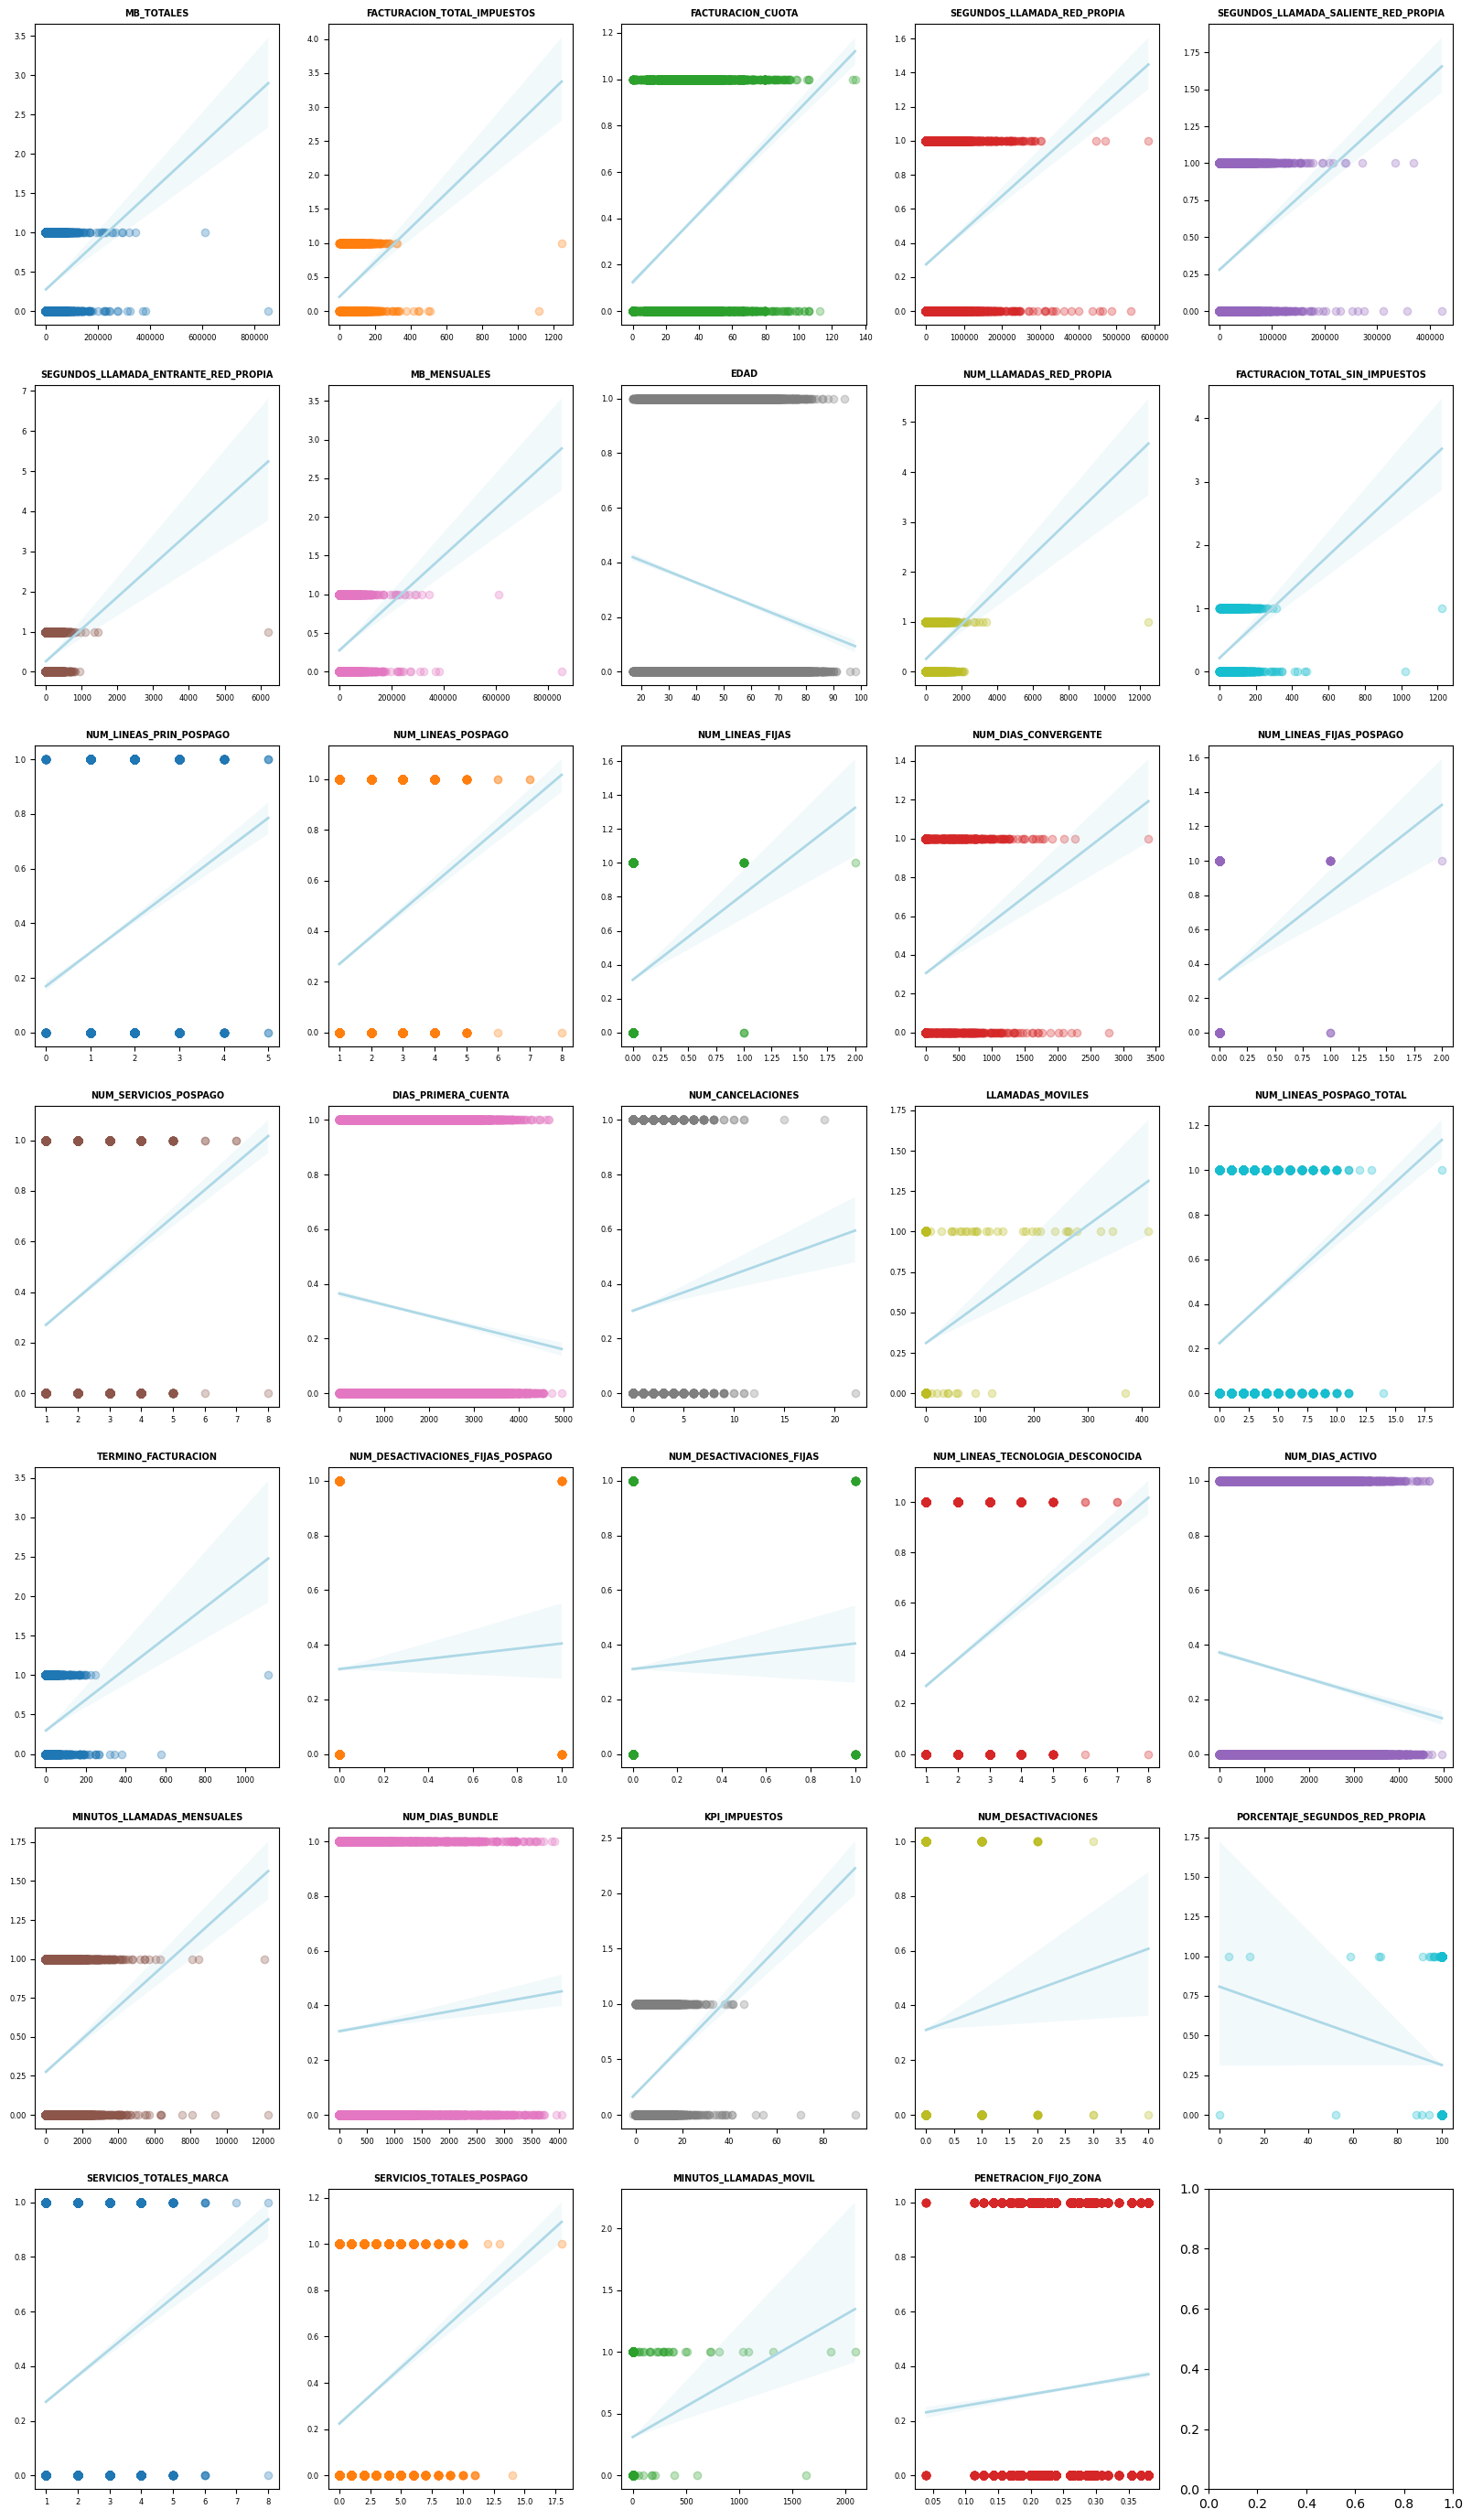

In [9]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(20, 35))
axes = axes.flatten()
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop(['MES', 'TARGET'])
colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

for i, col in enumerate(columnas_numeric):
    sns.regplot(
        data=df,
        x=col,
        y='TARGET',
        color=colors[i % len(colors)],
        line_kws={'color': 'lightblue', 'linewidth': 2},
        scatter_kws={'alpha': 0.3}
    , ax=axes[i])
    axes[i].set_title(col, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].grid(False)
plt.show()

Tipos de gráficas a observar:
1. Positivas: Gráficas donde a medida que aumenta la variable independiente ('TARGET'), el valor de la variable aumenta
    - MB_TOTALES (Cuando más MB totales consumidos, más posivilidad de adquirir un producto adicional)
    - FACTURACION_TOTAL_IMPUESTOS (Cuando más facturación total de impuestos, más posivilidad de adquirir un producto adicional)
    - FACTURACION_CUOTA (Cuando más facturación haya, más posivilidad de adquirir un producto adicional)
    - [...]

2. Negativas: Gráficas donde a medida que disminuye la variable independiente, el valor de la variable aumenta, lo que provoca un cliente no adquiera un producto adicional:
    - EDAD (Cuando más edad, menos posivilidad de adquirir un producto adicional)
    - NUM_DIAS_ACTIVO (Cuantos mas dias activos, menos posivilidad de adquirir un producto adicional)
    - DIA_PRIMERA_CUENTA (Cuatos mas dias pasen con una cuenta recien echa,  menos posivilidad de adquirir un producto adicional)

### 1.4. Tratamiento de nulos

<Axes: >

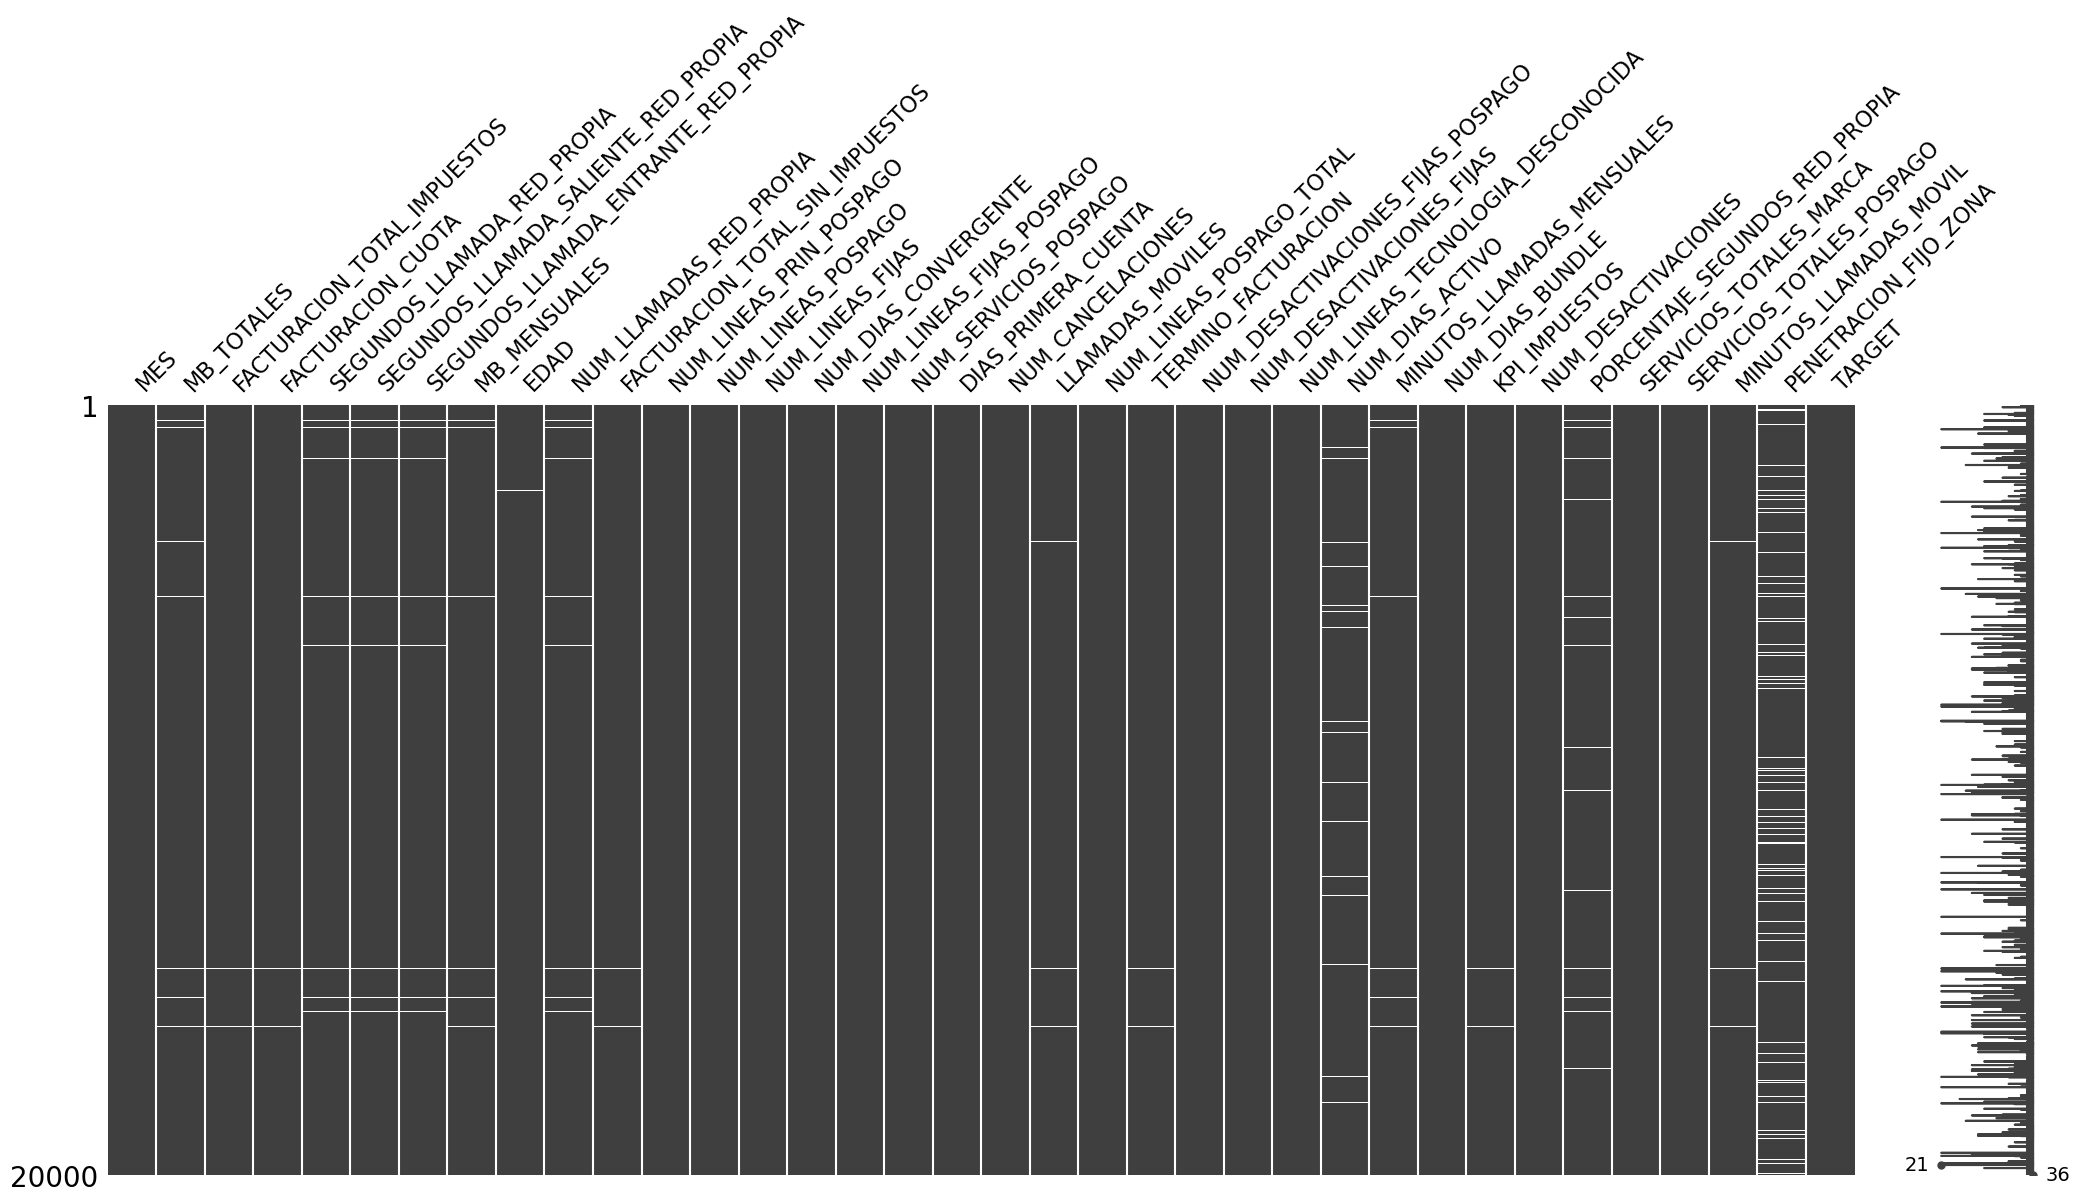

In [10]:
msno.matrix(df)

<Axes: >

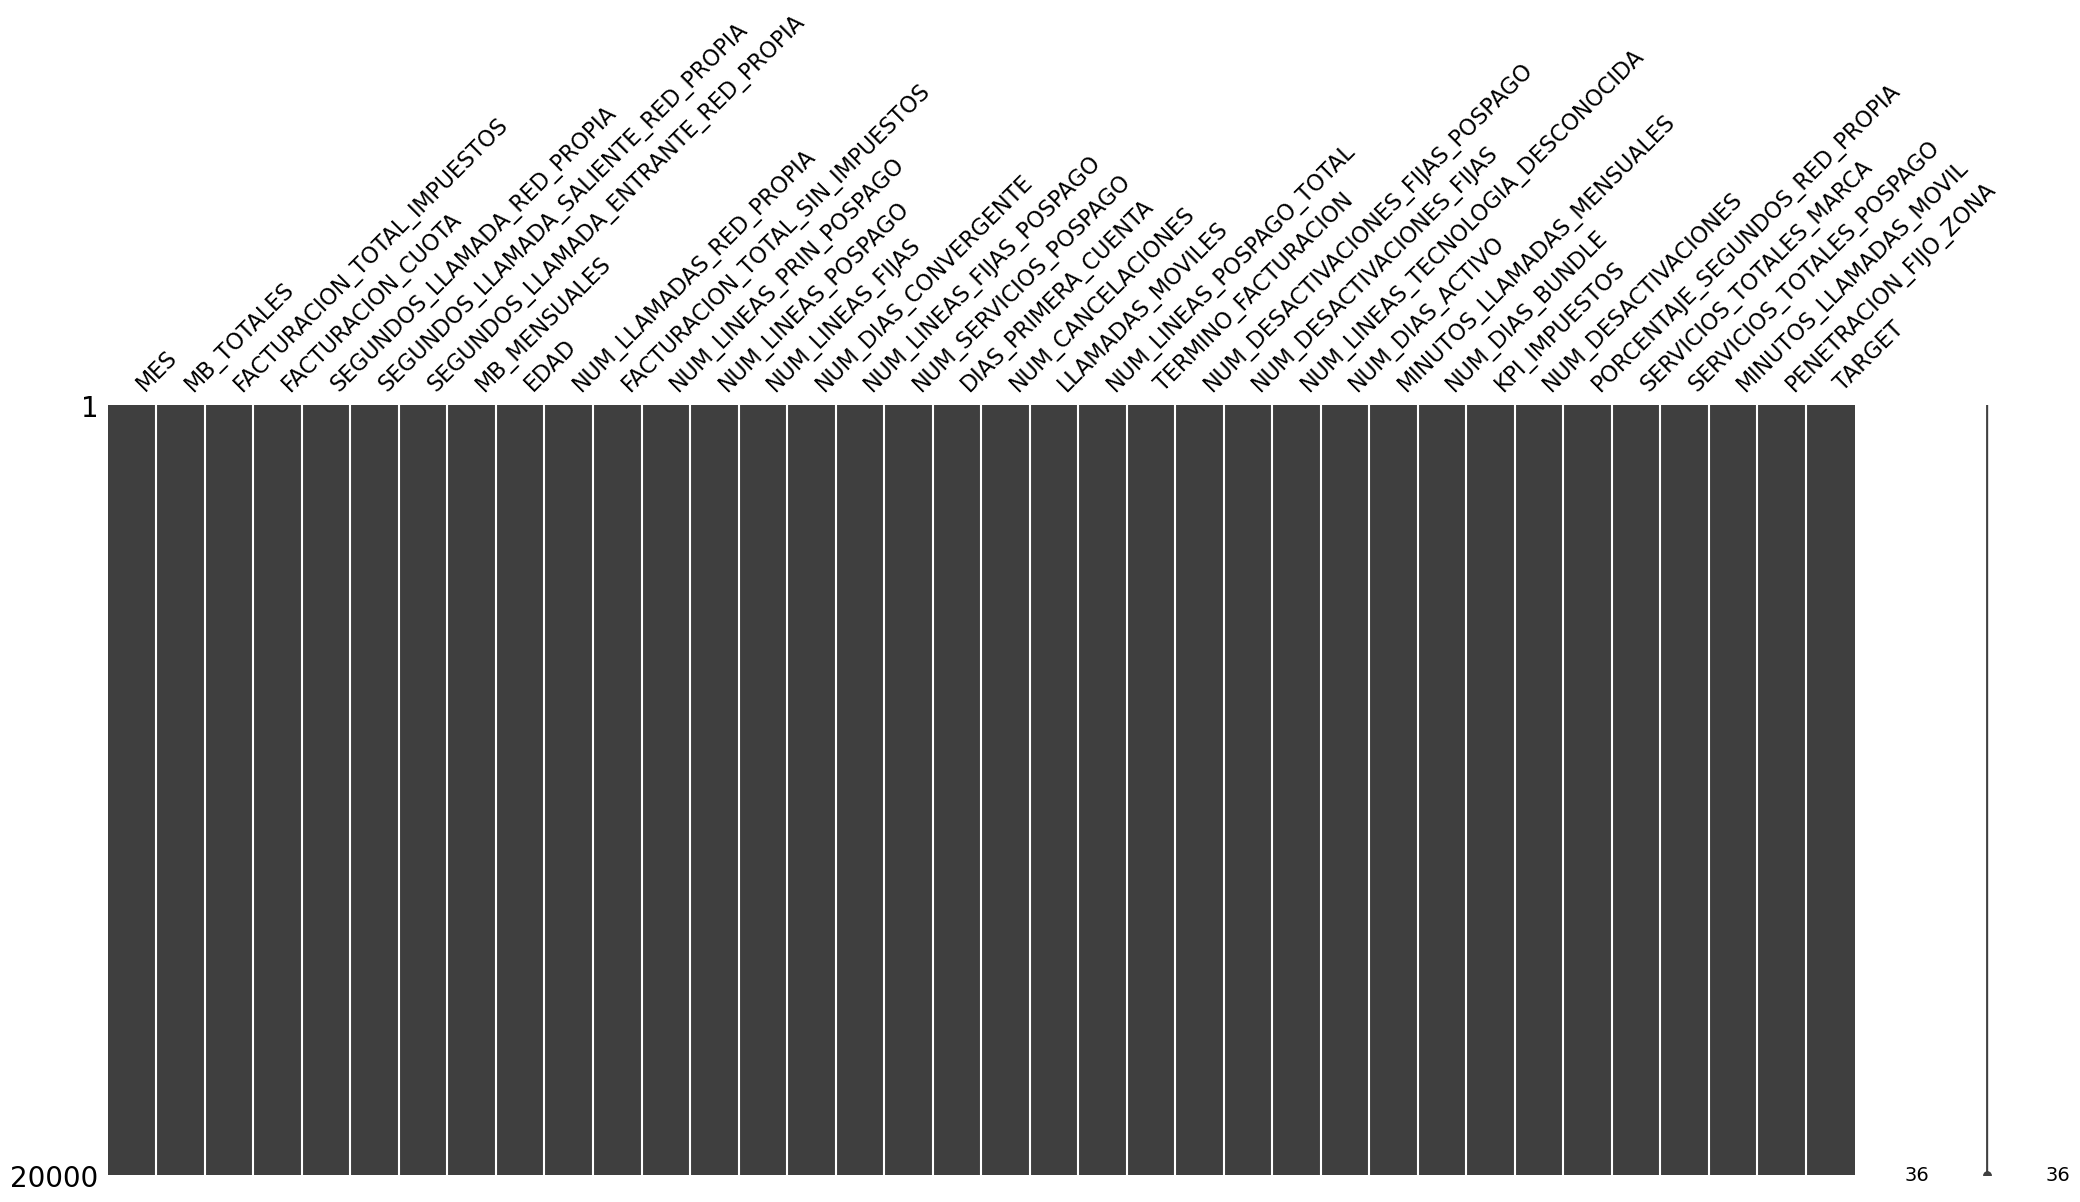

In [11]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
msno.matrix(df)

### 1.5. Distribucion de la variable objetivo

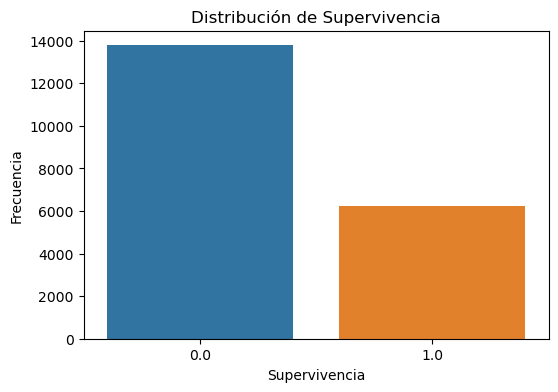

In [12]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='TARGET')
plt.title('Distribución de Supervivencia')
plt.xlabel('Supervivencia')
plt.ylabel('Frecuencia')
plt.grid(False)
plt.show()

### 1.6. Outliers

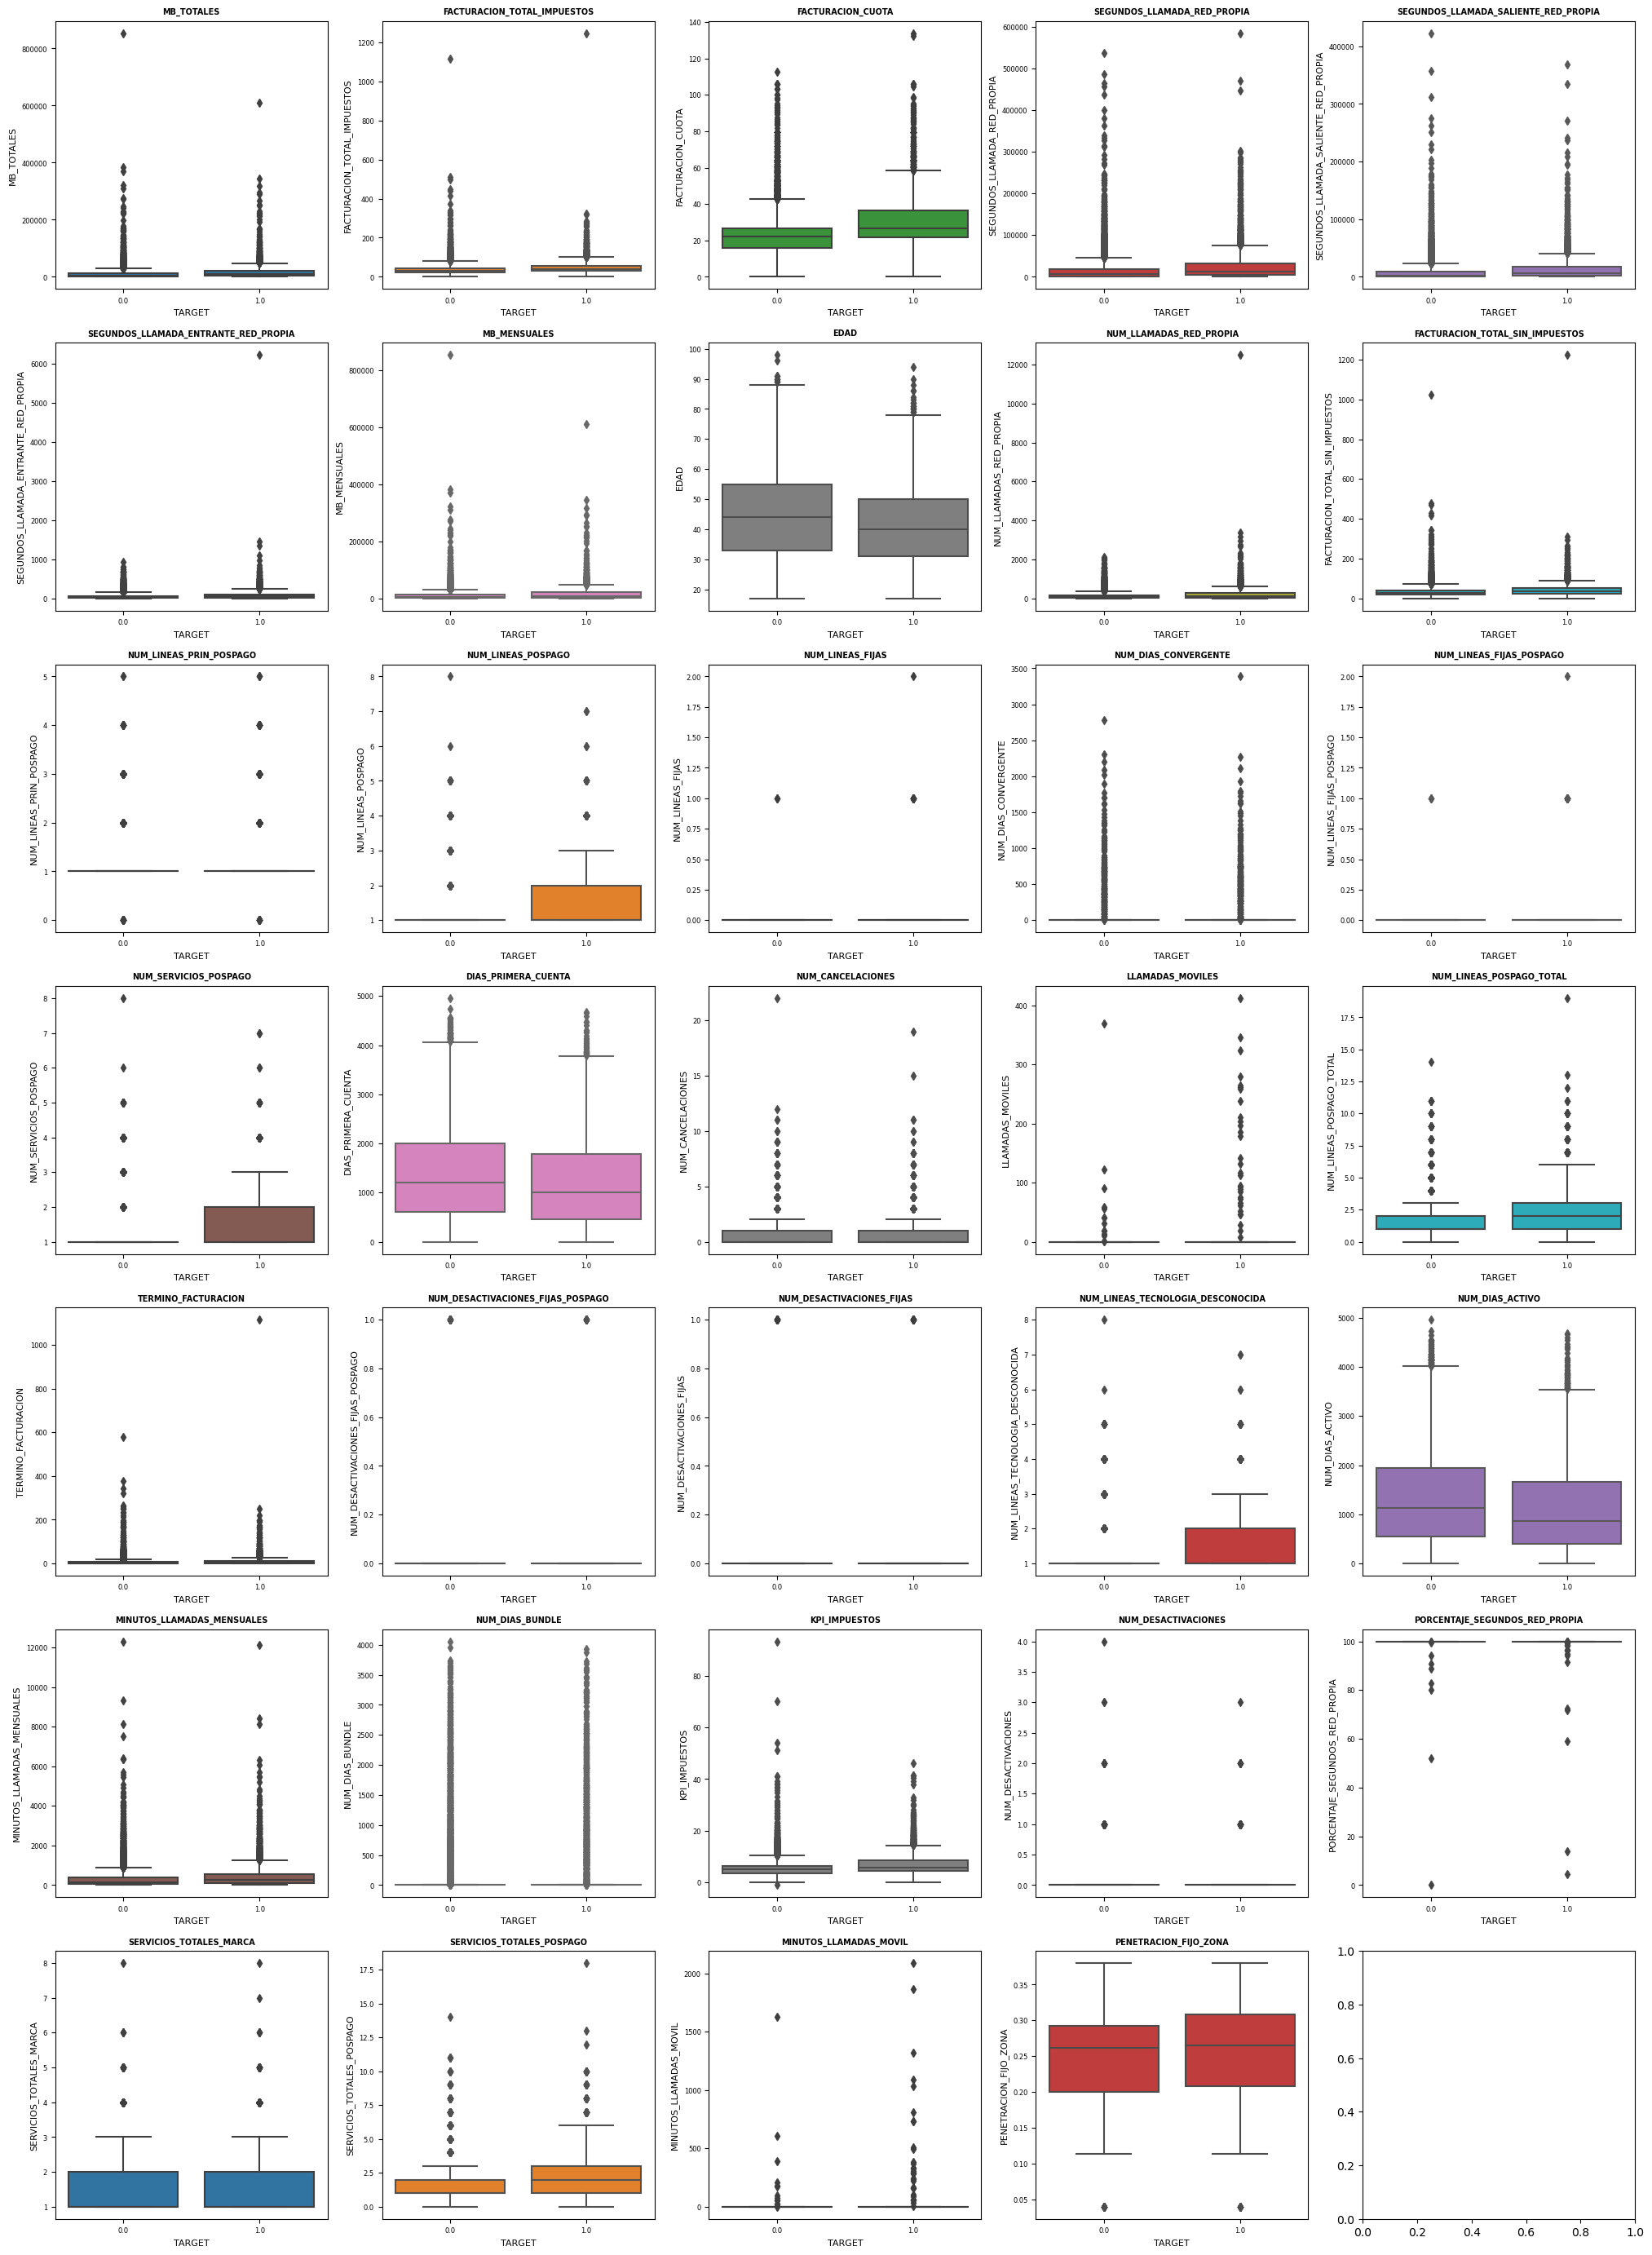

In [13]:
fig, axes = plt.subplots(nrows=7, ncols=5, figsize=(25, 35))
axes = axes.flatten()
colors = [color['color'] for color in plt.rcParams['axes.prop_cycle']]

for i, col in enumerate(columnas_numeric):
    sns.boxplot(
        data=df,
        y=col,
        x='TARGET',
        color=colors[i % len(colors)],
        ax=axes[i]
    )
    axes[i].set_title(col, fontsize=7, fontweight="bold")
    axes[i].tick_params(labelsize=6)
    axes[i].set_ylabel(col, fontsize=8)
    axes[i].set_xlabel('TARGET', fontsize=8)
    axes[i].grid(False)
plt.show()

In [14]:
df_outliers = df.select_dtypes(include=['float64', 'int64'])

for column in df_outliers.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_above = df[column] > upper_bound
    outliers_below = df[column] < lower_bound

    total_muestras = len(df[column])
    outliers = outliers_above.sum() + outliers_below.sum()
    porcentaje_outliers = (outliers / total_muestras) * 100

    print(f"Número total de muestras de {column}: {total_muestras}")
    print(f"Número de outliers totales:\n{outliers}")
    print(f"Porcentaje de outliers totales:\n{porcentaje_outliers:.2f} %")
    print(f"---------------------------------------------------------")

Número total de muestras de MES: 20000
Número de outliers totales:
0
Porcentaje de outliers totales:
0.00 %
---------------------------------------------------------
Número total de muestras de MB_TOTALES: 20000
Número de outliers totales:
1317
Porcentaje de outliers totales:
6.59 %
---------------------------------------------------------
Número total de muestras de FACTURACION_TOTAL_IMPUESTOS: 20000
Número de outliers totales:
1042
Porcentaje de outliers totales:
5.21 %
---------------------------------------------------------
Número total de muestras de FACTURACION_CUOTA: 20000
Número de outliers totales:
1791
Porcentaje de outliers totales:
8.96 %
---------------------------------------------------------
Número total de muestras de SEGUNDOS_LLAMADA_RED_PROPIA: 20000
Número de outliers totales:
1814
Porcentaje de outliers totales:
9.07 %
---------------------------------------------------------
Número total de muestras de SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA: 20000
Número de outlier

### 1.7. Análisis de correlación

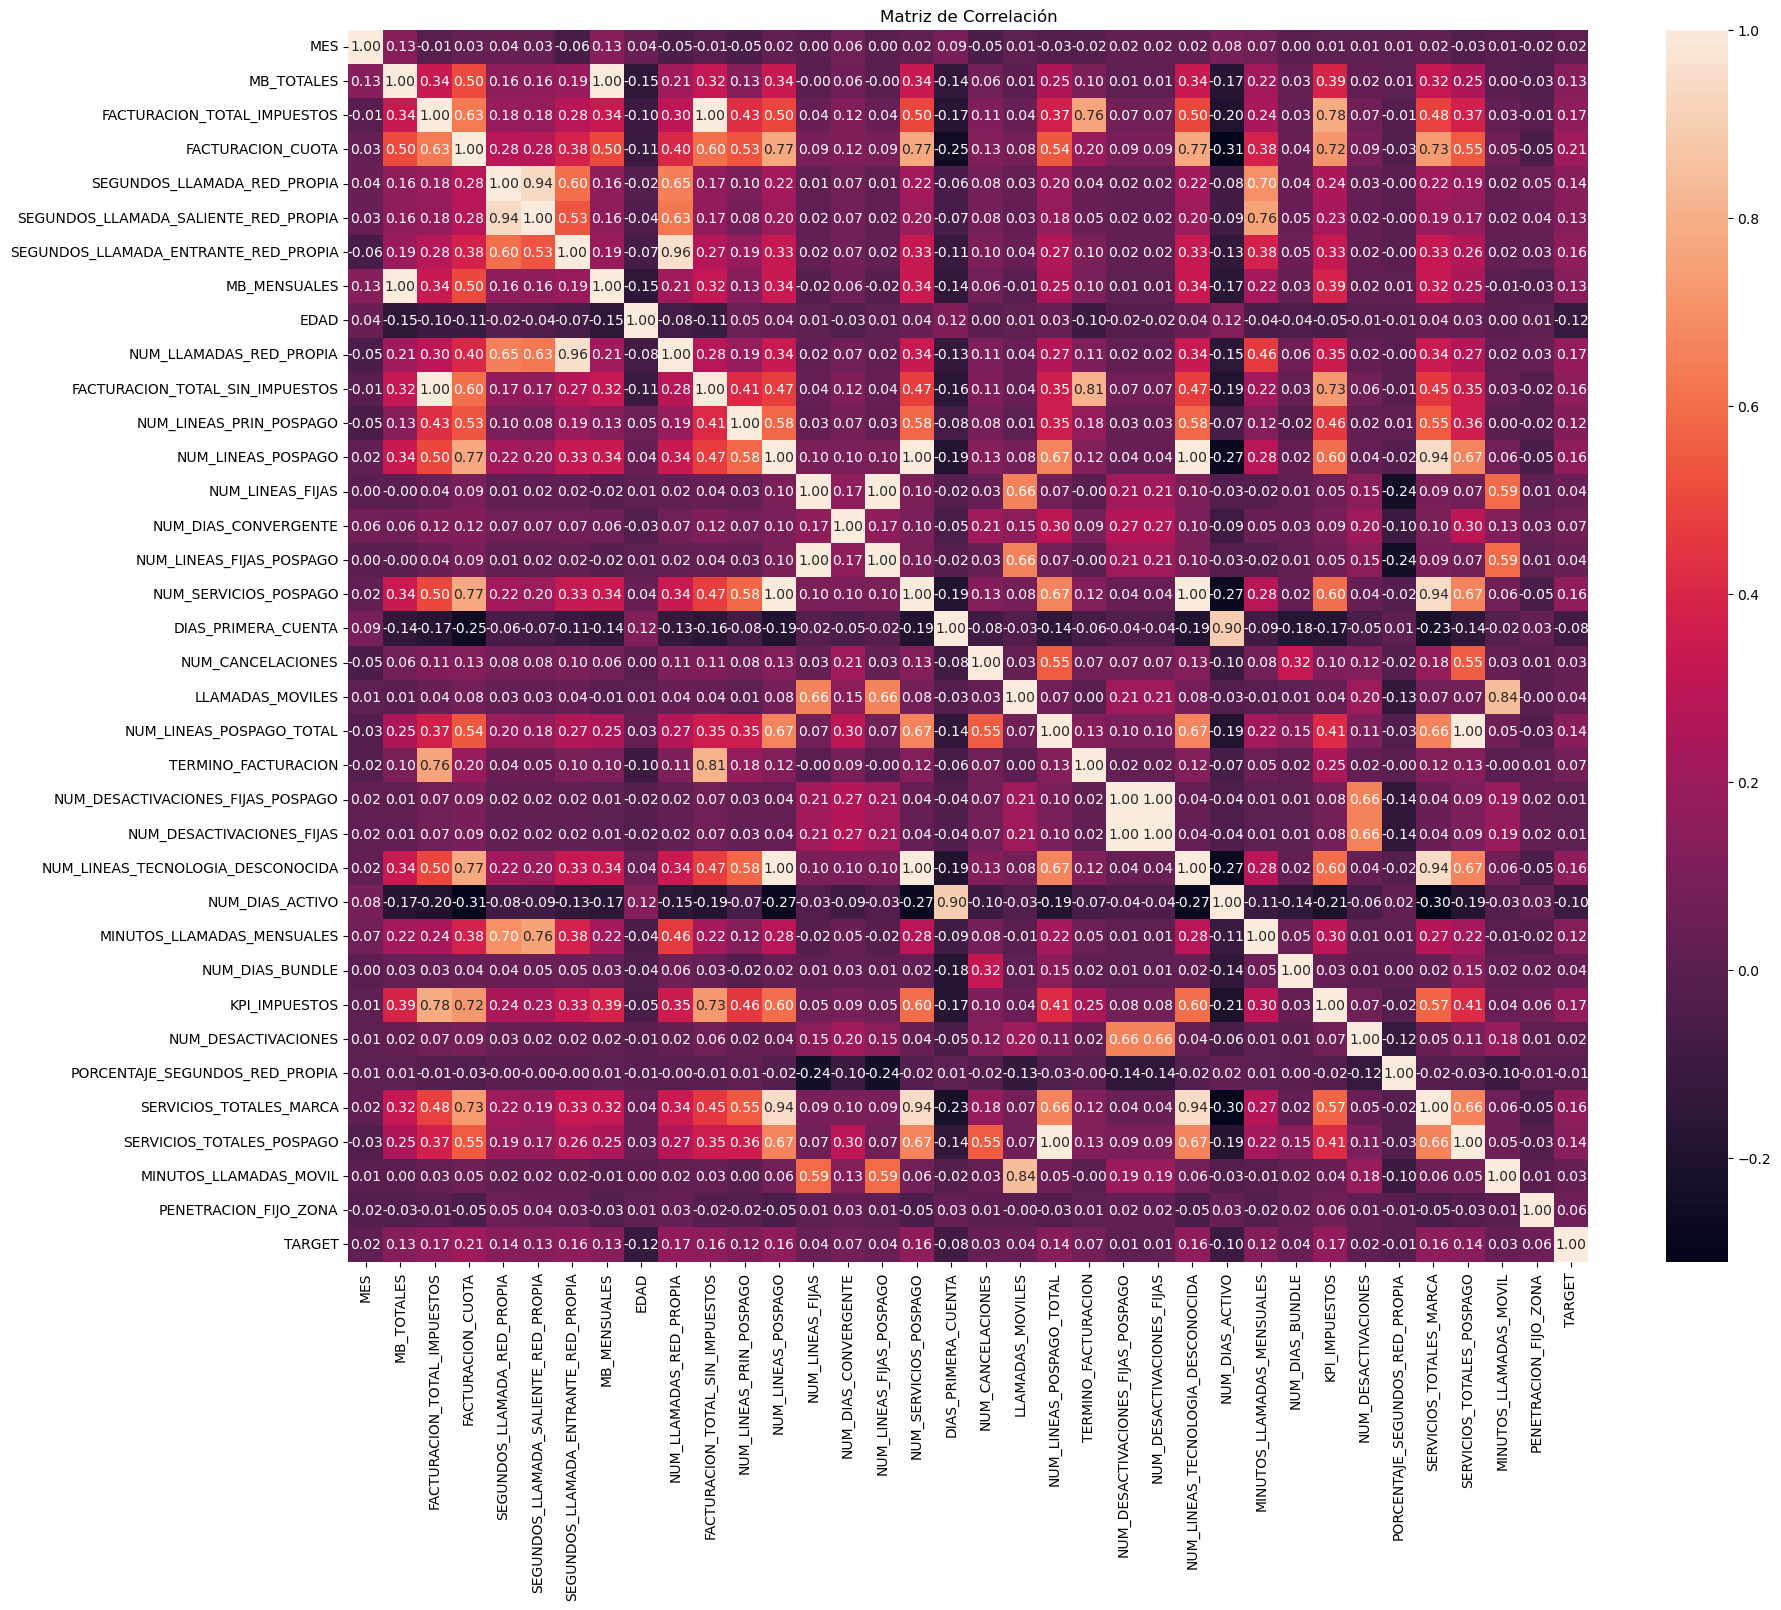

In [15]:
matriz_correlaciones = df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(matriz_correlaciones, annot=True, fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Observaciones de correlación:
 - Numerosas variables con correlacion de 1, lo que significa que ocupan los mismos valores, ya que aumentan paralelamente.

 Observaciones de datos:

Interpretación de colores: 
- MB_TOTALES se mide en meses (correlación 1 respecto MB_MENSUALES)
- Los usuarios que se crean recientemente una cuenta suelen estar muy activos
- Cuantos más errores en el servicio(NUM_DIAS_BUNDLE), menos actividad (NUM_DIAS_ACTIVO)
- [...]

Referencias:

 - Documentación vista en clase (Regresion_PrecioDiamantes.ipynb)

 - [Interpretación de correlación](https://www.cimec.es/coeficiente-correlacion-pearson/#:~:text=Un%20valor%20mayor%20que%200,una%20relaci%C3%B3n%20lineal%20positiva%20perfecta.)

 Valores de coorelacion similar como (NUM_DESACTIVACIONES_FIJAS_POSPAGO y NUM_DESACTIVACIONES_FIJAS) y (NUM_LINEAS_TECNOLOGIA_DESCONOCIDA y NUM_SERVICIOS_POSPAGO), por lo que al tener estas los mismos valores se procede a la eliminacion de una de las 2

In [16]:
if 'NUM_DESACTIVACIONES_FIJAS' in df.columns:
    df = df.rename(columns={'NUM_DESACTIVACIONES_FIJAS_POSPAGO': 'DESACTIVACIONES_FIJAS_POSPAGO_INCL_DESACTIVACIONES_FIJAS'})
    df = df.drop(columns=['NUM_DESACTIVACIONES_FIJAS'])

if 'NUM_LINEAS_TECNOLOGIA_DESCONOCIDA' in df.columns:
    df = df.rename(columns={'NUM_SERVICIOS_POSPAGO': 'SERVICIOS_POSPAGO_INCL_LINEAS_TECNOLOGIA_DESCONOCIDA'})
    df = df.drop(columns=['NUM_LINEAS_TECNOLOGIA_DESCONOCIDA'])

## 2. Preparación de los datos para el modelado

### 2.1. Selección de variables de entrenamiento.

In [17]:
X = df.drop(['TARGET', 'MES'], axis=1)
y = df['TARGET']

### 2.2. Estandarización

In [18]:
columnas_num = X.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
x_scaled = scaler.fit_transform(columnas_num)
x_estandarizado = pd.DataFrame(x_scaled, columns=X.columns)
X = X.drop(columns=columnas_num.columns).reset_index(drop=True)
X = pd.concat([X, x_estandarizado], axis=1)
X.head()

,MB_TOTALES,FACTURACION_TOTAL_IMPUESTOS,FACTURACION_CUOTA,SEGUNDOS_LLAMADA_RED_PROPIA,SEGUNDOS_LLAMADA_SALIENTE_RED_PROPIA,SEGUNDOS_LLAMADA_ENTRANTE_RED_PROPIA,MB_MENSUALES,EDAD,NUM_LLAMADAS_RED_PROPIA,FACTURACION_TOTAL_SIN_IMPUESTOS,...,NUM_DIAS_ACTIVO,MINUTOS_LLAMADAS_MENSUALES,NUM_DIAS_BUNDLE,KPI_IMPUESTOS,NUM_DESACTIVACIONES,PORCENTAJE_SEGUNDOS_RED_PROPIA,SERVICIOS_TOTALES_MARCA,SERVICIOS_TOTALES_POSPAGO,MINUTOS_LLAMADAS_MOVIL,PENETRACION_FIJO_ZONA
0,-0.600291,-1.013029,-1.929729,-0.463900,-0.482036,-0.372425,-0.599420,-0.353376,-0.448411,-0.970581,...,-1.289191,-0.625843,-0.312466,-1.096173,-0.075229,0.020414,0.749386,-0.596120,-0.03024,0.097753
1,0.300743,-0.294611,0.097630,-0.187179,-0.058454,-0.147211,0.301832,-1.345062,-0.017141,-0.319458,...,-0.923003,-0.358877,0.601041,-0.028405,-0.075229,0.020414,-0.571700,0.155845,-0.03024,1.718327
2,-0.504958,-0.115591,0.477041,-0.606285,-0.543899,-0.672710,-0.504064,0.213302,-0.668446,0.003724,...,0.146735,-0.464652,-0.312466,-1.018865,-0.075229,0.020414,0.749386,0.155845,-0.03024,-1.424824
3,-0.453022,-0.689858,-0.662725,-0.606696,-0.544587,-0.672710,-0.452116,-0.070037,-0.686049,-0.677666,...,-1.171755,-0.544262,-0.312466,-0.615971,-0.075229,0.020414,0.749386,0.907810,-0.03024,-0.404328
4,0.667473,-0.129980,0.097630,1.691144,0.915239,0.946685,0.668651,-0.282541,0.761784,-0.138909,...,1.017900,0.295071,-0.310366,-0.028405,-0.075229,0.020414,-0.571700,-0.596120,-0.03024,-0.664111


In [19]:
lof = LocalOutlierFactor(n_neighbors=30)

y_pred = lof.fit_predict(X)

df['outlier'] = y_pred

outliers = df[df['outlier'] == -1]
inliers = df[df['outlier'] == 1]

total_muestras = len(df)

num_outliers = df['outlier'].value_counts().get(-1, 0)

porcentaje_outliers = (num_outliers / total_muestras) * 100

print(f'Número total de muestras: {total_muestras}')
print(f'Número de outliers: {num_outliers}')
print(f'Porcentaje de outliers: {porcentaje_outliers:.2f}%')


Número total de muestras: 20000
Número de outliers: 536
Porcentaje de outliers: 2.68%


In [20]:
file = './caso_final_small_20k_con_mes_v2.csv'

if not os.path.isfile(file):
    df.to_csv(file, index=False)
else:
    print('Archivo cargado correctamente')

Archivo cargado correctamente


### 2.3 División del dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(u'Dimensiones en train \n-x:{}\n-y:{}'.format(X_train.shape, y_train.shape))
print(u'Dimensiones en test \n-x:{}\n-y:{}'.format(X_test.shape, y_test.shape))

Dimensiones en train 
-x:(16000, 32)
-y:(16000,)
Dimensiones en test 
-x:(4000, 32)
-y:(4000,)


## 3. Comparación del rendimiento de varios modelos

### 3.1. Regresión Logística

In [22]:
logistic_regression = LogisticRegression()

In [23]:
y_test_pred_model, y_test_prob_model = model_fit(model=logistic_regression, X_train=X_train, y_train=y_train, X_test=X_test)

Ejemplo de predicción: [[0.67872617 0.32127383]]


- Precision: 0.55
- Recall: 0.1508656224237428
- Fscore: 0.24
- AUC: 0.67


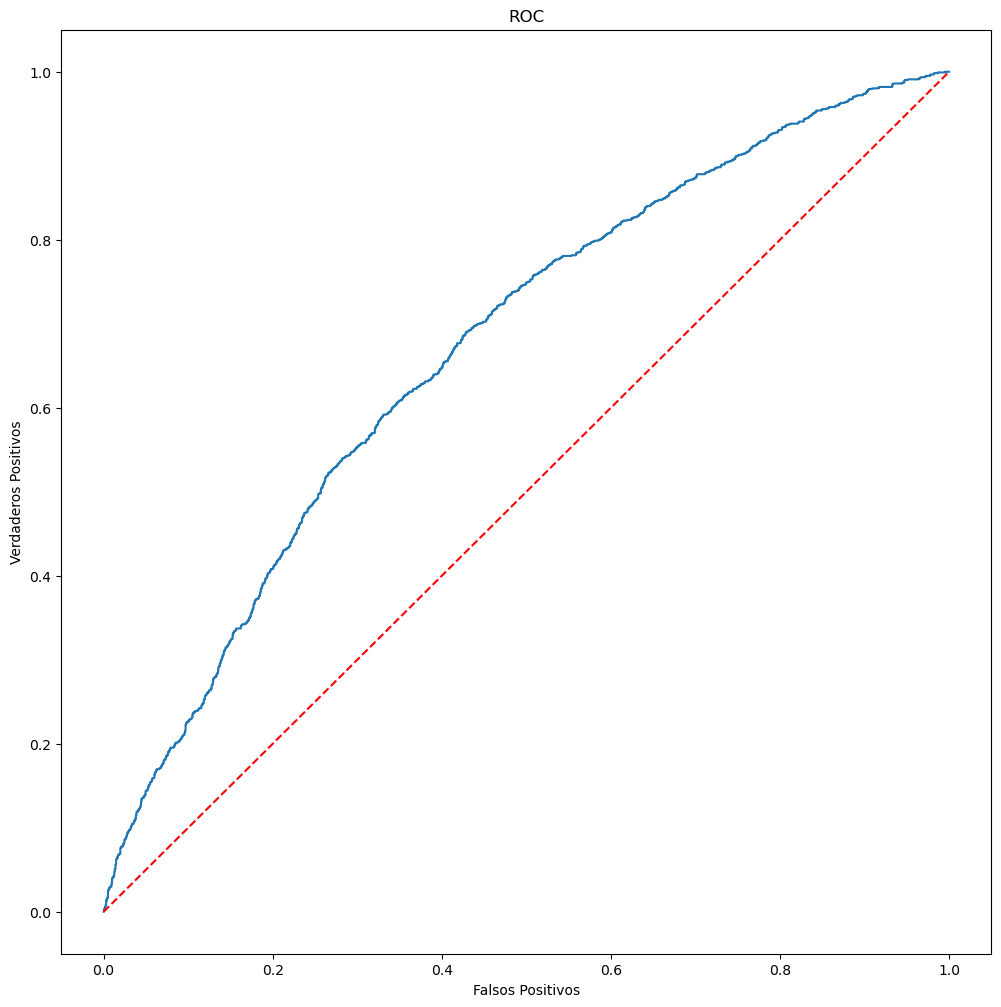

In [24]:
evaluate_model(y_test=y_test, y_test_prob=y_test_prob_model, y_test_pred=y_test_pred_model)

### 3.2. Modelo ensamblado

[Bagging](http://eio.usc.es/pub/mte/descargas/ProyectosFinMaster/Proyecto_1686.pdf)

In [25]:
random_forest_classifier = RandomForestClassifier()

In [26]:
y_test_pred_model, y_test_prob_model = model_fit(model=random_forest_classifier, X_train=X_train, y_train=y_train, X_test=X_test)

Ejemplo de predicción: [[0.64 0.36]]


- Precision: 0.51
- Recall: 0.2291838417147568
- Fscore: 0.32
- AUC: 0.66


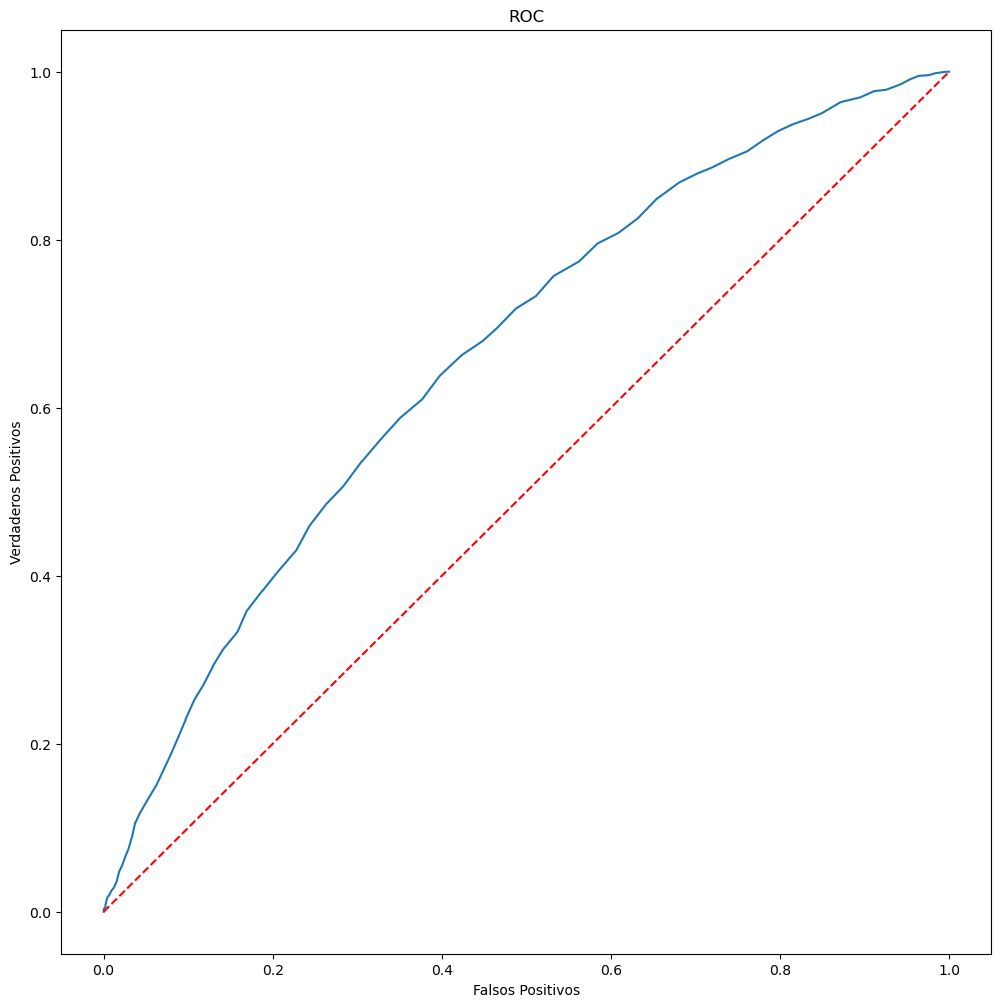

In [27]:
evaluate_model(y_test=y_test, y_test_prob=y_test_prob_model, y_test_pred=y_test_pred_model)

### 3.3. Red neuronal (MLP)

In [28]:
mlp = MLPClassifier()

In [29]:
y_test_pred_model, y_test_prob_model = model_fit(model=mlp, X_train=X_train, y_train=y_train, X_test=X_test)

Ejemplo de predicción: [[0.81577097 0.18422903]]


- Precision: 0.45
- Recall: 0.20610057708161583
- Fscore: 0.28
- AUC: 0.64


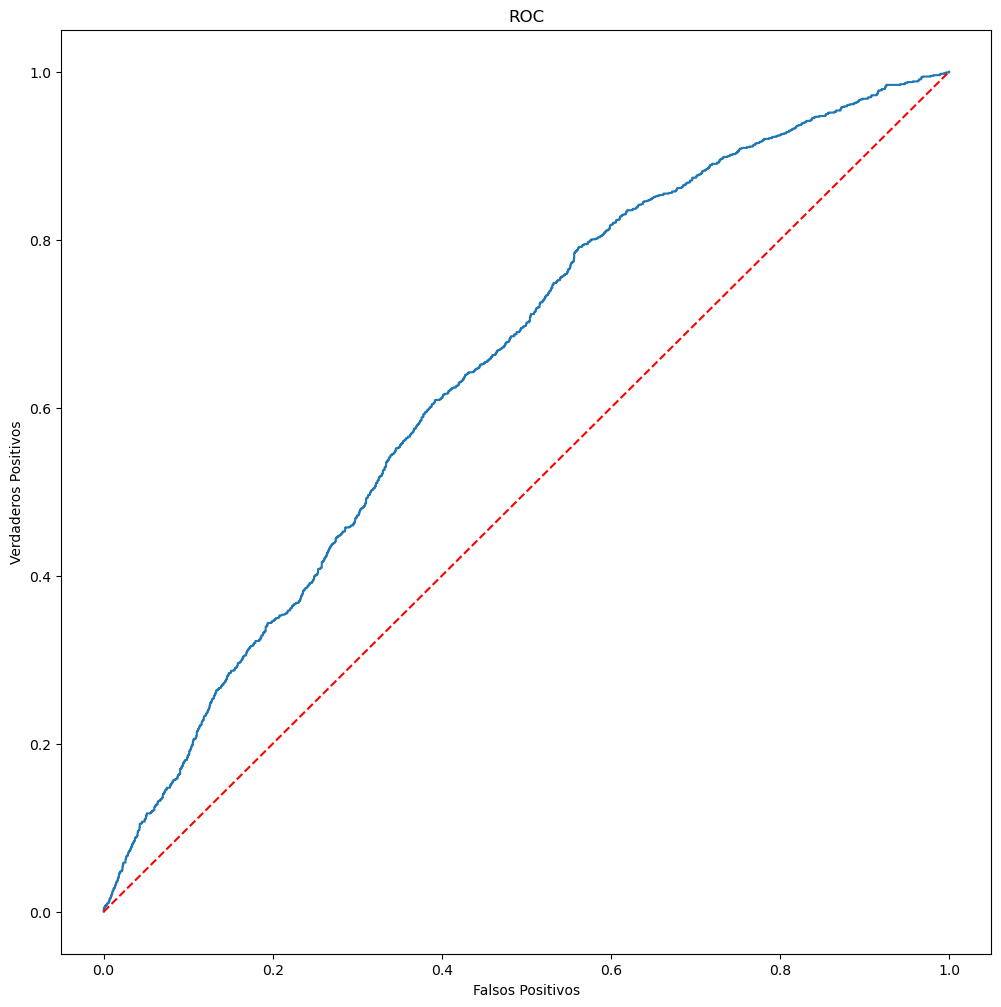

In [30]:
evaluate_model(y_test=y_test, y_test_prob=y_test_prob_model, y_test_pred=y_test_pred_model)

### 3.4 Eliminación de Outliers

In [31]:
outlier_indices = df[df['outlier'] == -1].index

X_cleaned = X.drop(index=outlier_indices).reset_index(drop=True)
y_cleaned = y.drop(index=outlier_indices).reset_index(drop=True)

### 3.5. División del dataset sin Outliers

In [32]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=0)

print(u'Dimensiones en train \n-x:{}\n-y:{}'.format(X_train2.shape, y_train2.shape))
print(u'Dimensiones en test \n-x:{}\n-y:{}'.format(X_test2.shape, y_test2.shape))

Dimensiones en train 
-x:(15571, 32)
-y:(15571,)
Dimensiones en test 
-x:(3893, 32)
-y:(3893,)


### 3.6. Regresión Logística sin Outliers

In [33]:
logistic_regression = LogisticRegression()

In [34]:
y_test2_pred_model, y_test2_prob_model = model_fit(model=logistic_regression, X_train=X_train2, y_train=y_train2, X_test=X_test2)

Ejemplo de predicción: [[0.82915066 0.17084934]]


- Precision: 0.53
- Recall: 0.14939550949913644
- Fscore: 0.23
- AUC: 0.66


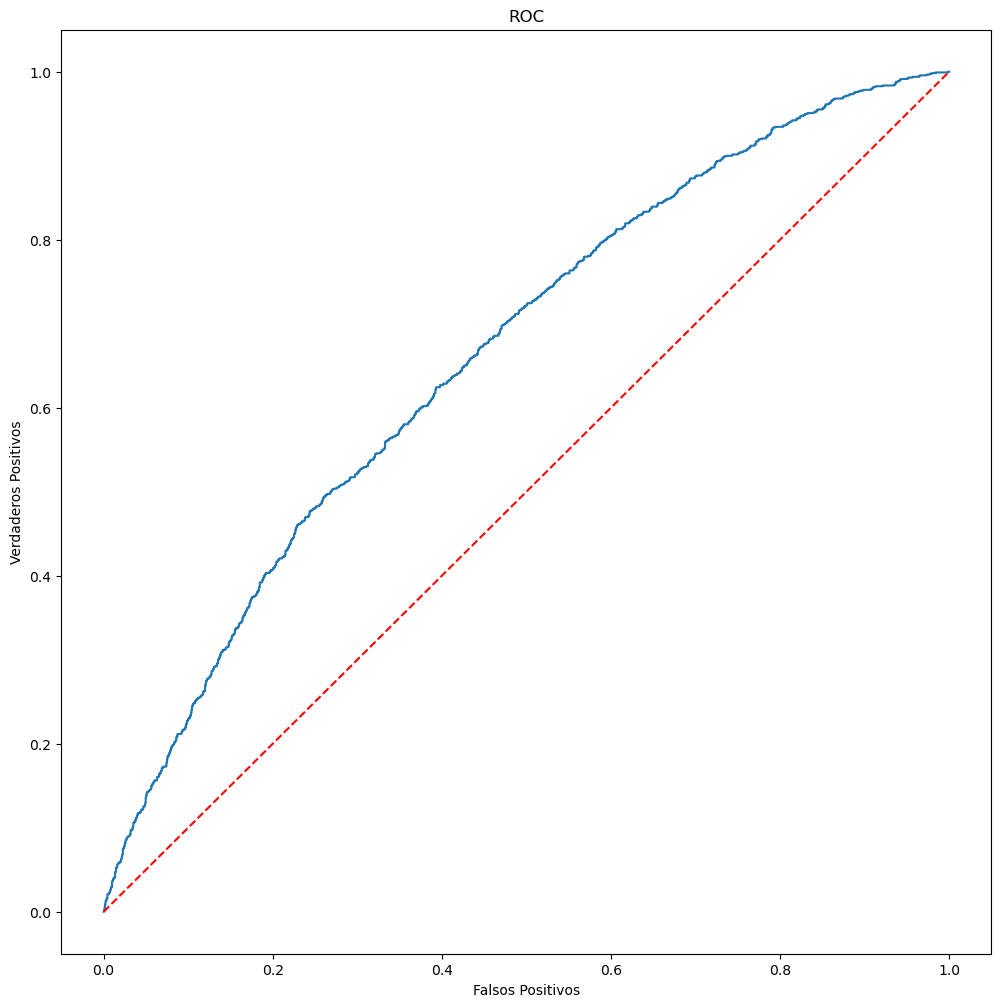

In [35]:
evaluate_model(y_test=y_test2, y_test_prob=y_test2_prob_model, y_test_pred=y_test2_pred_model)

### 3.7. Modelo ensamblado sin Outliers

In [36]:
random_forest_classifier = RandomForestClassifier()

In [37]:
y_test2_pred_model, y_test2_prob_model = model_fit(model=random_forest_classifier, X_train=X_train2, y_train=y_train2, X_test=X_test2)

Ejemplo de predicción: [[0.94 0.06]]


- Precision: 0.48
- Recall: 0.19602763385146804
- Fscore: 0.28
- AUC: 0.66


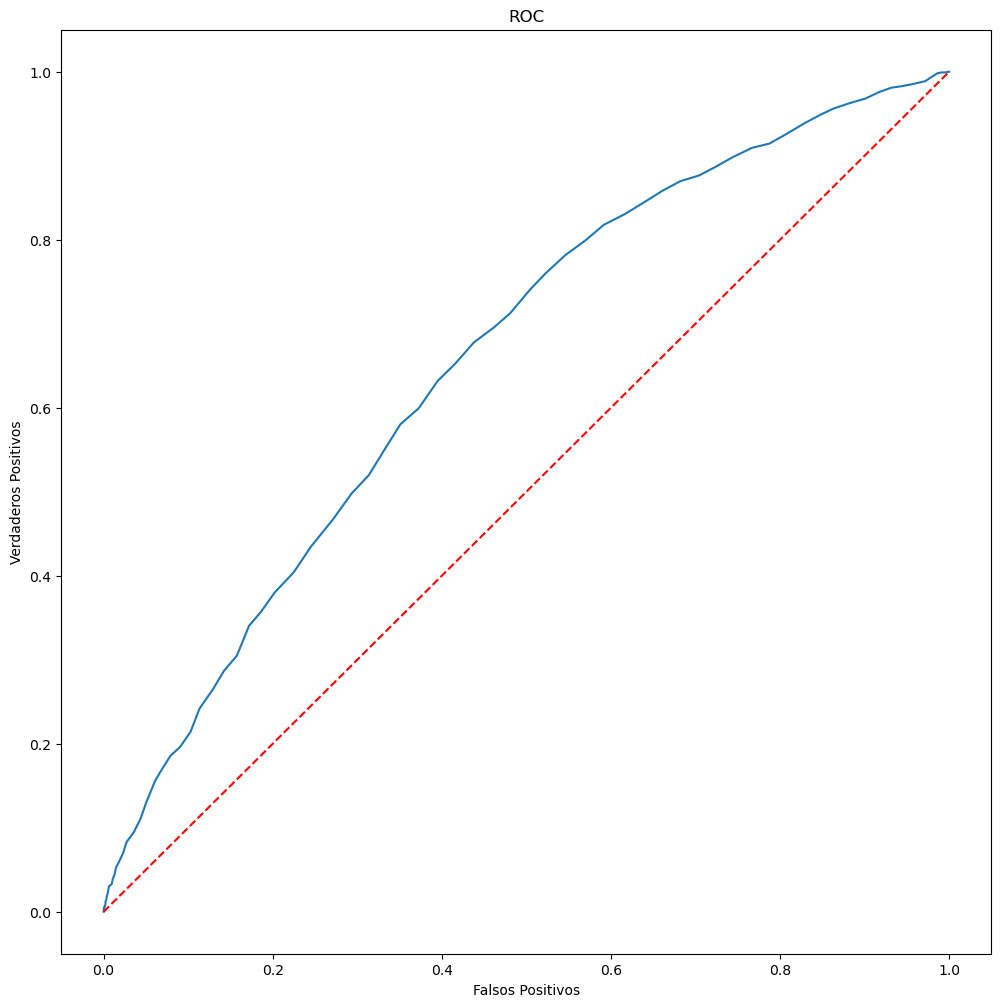

In [38]:
evaluate_model(y_test=y_test2, y_test_prob=y_test2_prob_model, y_test_pred=y_test2_pred_model)

### 3.8. Red neuronal (MLP) sin Outliers

In [39]:
mlp = MLPClassifier()

In [40]:
y_test2_pred_model, y_test2_prob_model = model_fit(model=mlp, X_train=X_train2, y_train=y_train2, X_test=X_test2)

Ejemplo de predicción: [[0.94765783 0.05234217]]


- Precision: 0.47
- Recall: 0.24179620034542315
- Fscore: 0.32
- AUC: 0.66


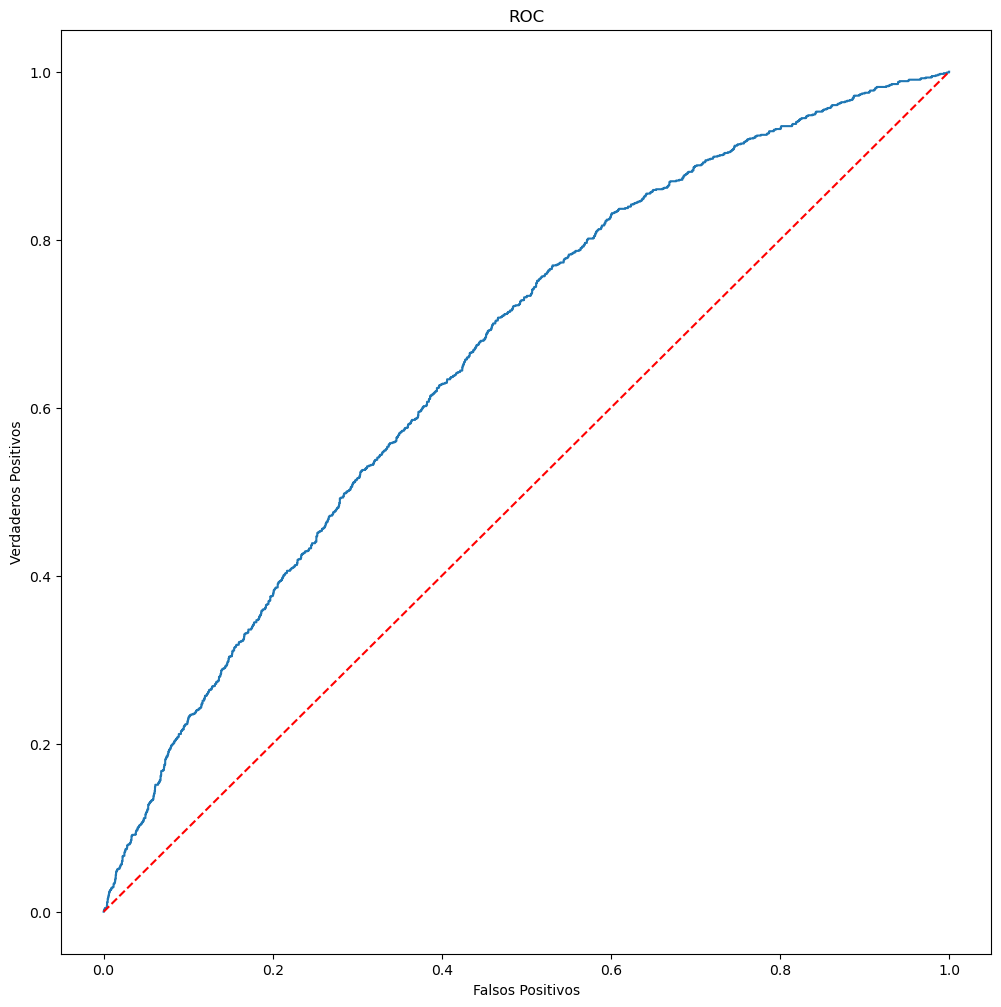

In [41]:
evaluate_model(y_test=y_test2, y_test_prob=y_test2_prob_model, y_test_pred=y_test2_pred_model)

## 4. Segmentación de clientes

In [42]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit(X)

etiquetas = cluster.labels_

df_clusters = pd.DataFrame(etiquetas, columns=['Cluster'])

X1 = X[df_clusters['Cluster'] == 0]
Y1 = y[df_clusters['Cluster'] == 0]
X2 = X[df_clusters['Cluster'] == 1]
Y2 = y[df_clusters['Cluster'] == 1]

print("Tamaño de X1:", X1.shape)
print("Tamaño de Y1:", Y1.shape)
print("Tamaño de X2:", X2.shape)
print("Tamaño de Y2:", Y2.shape)

Tamaño de X1: (5890, 32)
Tamaño de Y1: (5890,)
Tamaño de X2: (14110, 32)
Tamaño de Y2: (14110,)


### 4.1. División del dataset (Cluster 1)

In [43]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, Y1, test_size=0.2, random_state=0)

print(u'Dimensiones en train \n-x:{}\n-y:{}'.format(X1_train.shape, y1_train.shape))
print(u'Dimensiones en test \n-x:{}\n-y:{}'.format(X1_test.shape, y1_test.shape))

Dimensiones en train 
-x:(4712, 32)
-y:(4712,)
Dimensiones en test 
-x:(1178, 32)
-y:(1178,)


### 4.2. Regresión Logística (Cluster 1)

In [44]:
logistic_regression = LogisticRegression()

In [45]:
y1_test_pred_model, y1_test_prob_model = model_fit(model=logistic_regression, X_train=X1_train, y_train=y1_train, X_test=X1_test)

Ejemplo de predicción: [[0.63998676 0.36001324]]


- Precision: 0.62
- Recall: 0.2820976491862568
- Fscore: 0.39
- AUC: 0.64


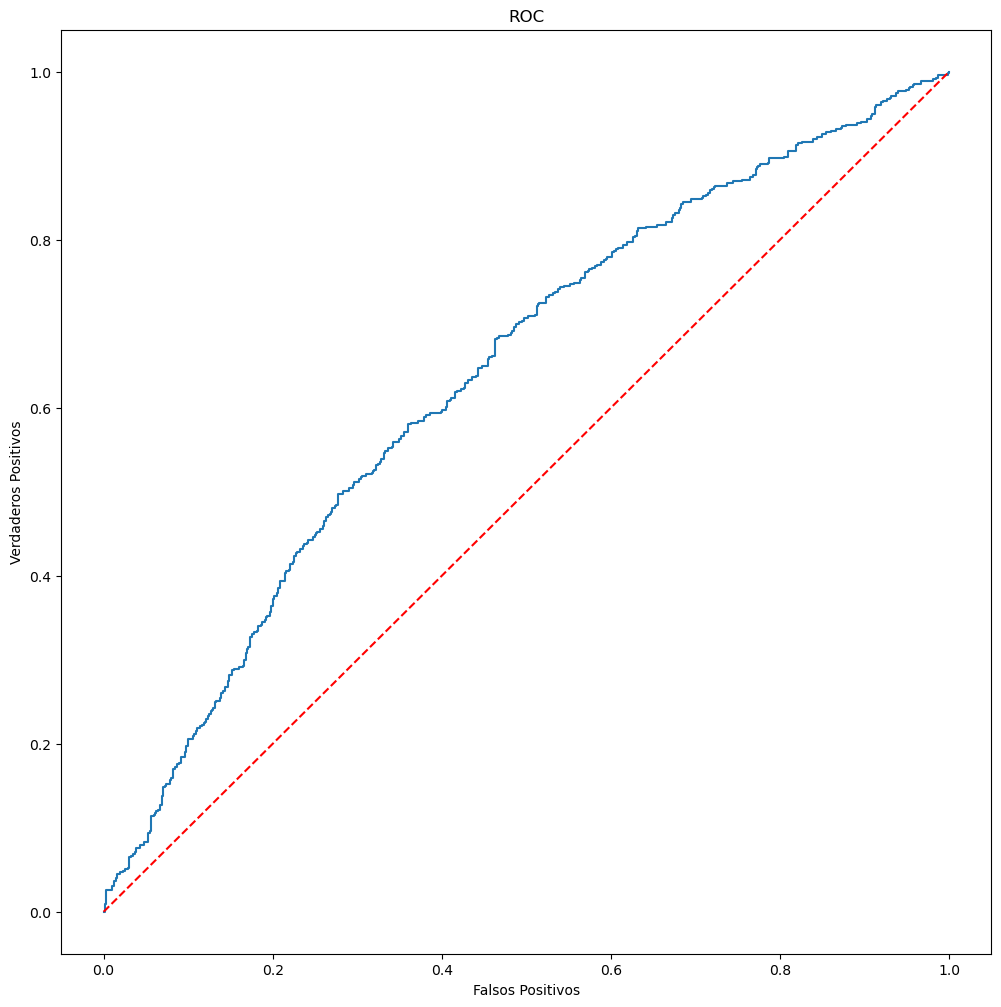

In [46]:
evaluate_model(y_test=y1_test, y_test_prob=y1_test_prob_model, y_test_pred=y1_test_pred_model)

### 4.3. Modelo ensamblado (Cluster 1)

In [47]:
random_forest_classifier = RandomForestClassifier()

In [48]:
y1_test_pred_model, y1_test_prob_model = model_fit(model=random_forest_classifier, X_train=X1_train, y_train=y1_train, X_test=X1_test)

Ejemplo de predicción: [[0.74 0.26]]


- Precision: 0.54
- Recall: 0.3345388788426763
- Fscore: 0.41
- AUC: 0.59


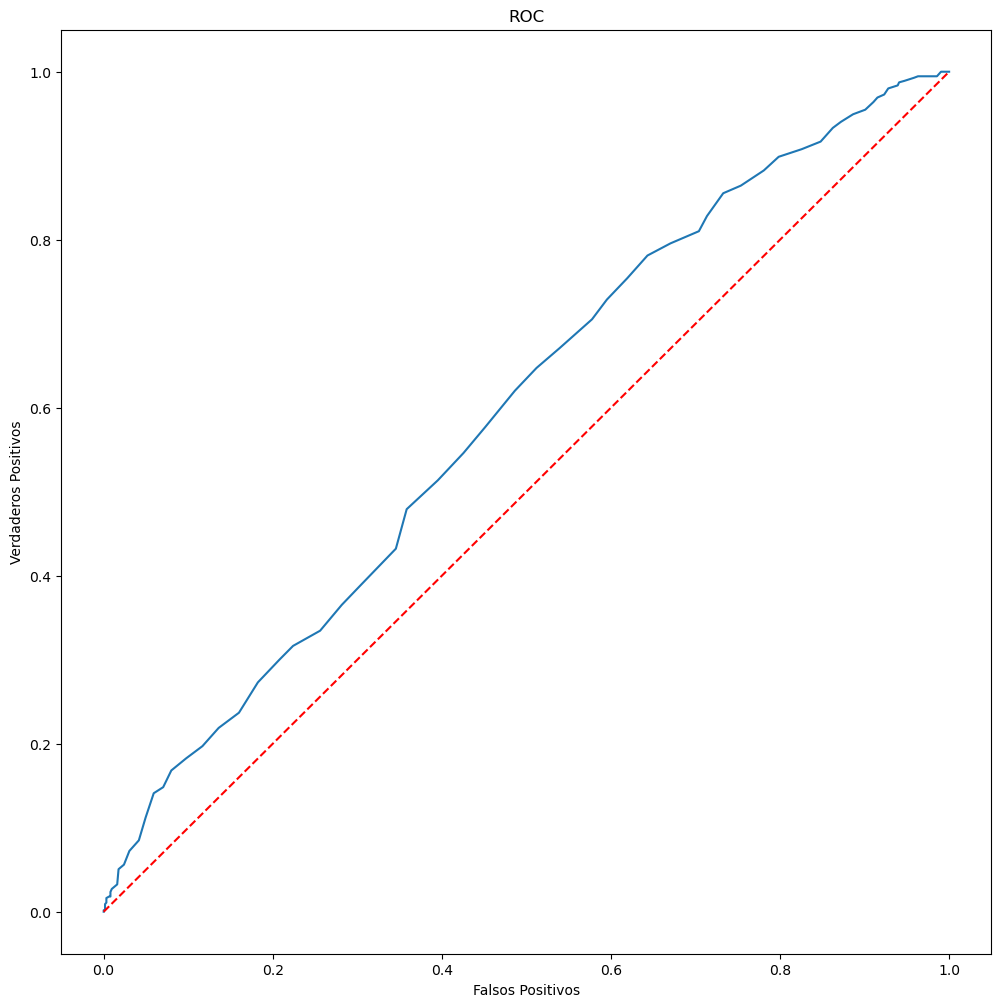

In [49]:
evaluate_model(y_test=y1_test, y_test_prob=y1_test_prob_model, y_test_pred=y1_test_pred_model)

### 4.4. Red neuronal (MLP) (Cluster 1)

In [50]:
mlp = MLPClassifier()

In [51]:
y1_test_pred_model, y1_test_prob_model = model_fit(model=mlp, X_train=X1_train, y_train=y1_train, X_test=X1_test)

Ejemplo de predicción: [[0.78475536 0.21524464]]


- Precision: 0.55
- Recall: 0.4358047016274864
- Fscore: 0.49
- AUC: 0.59


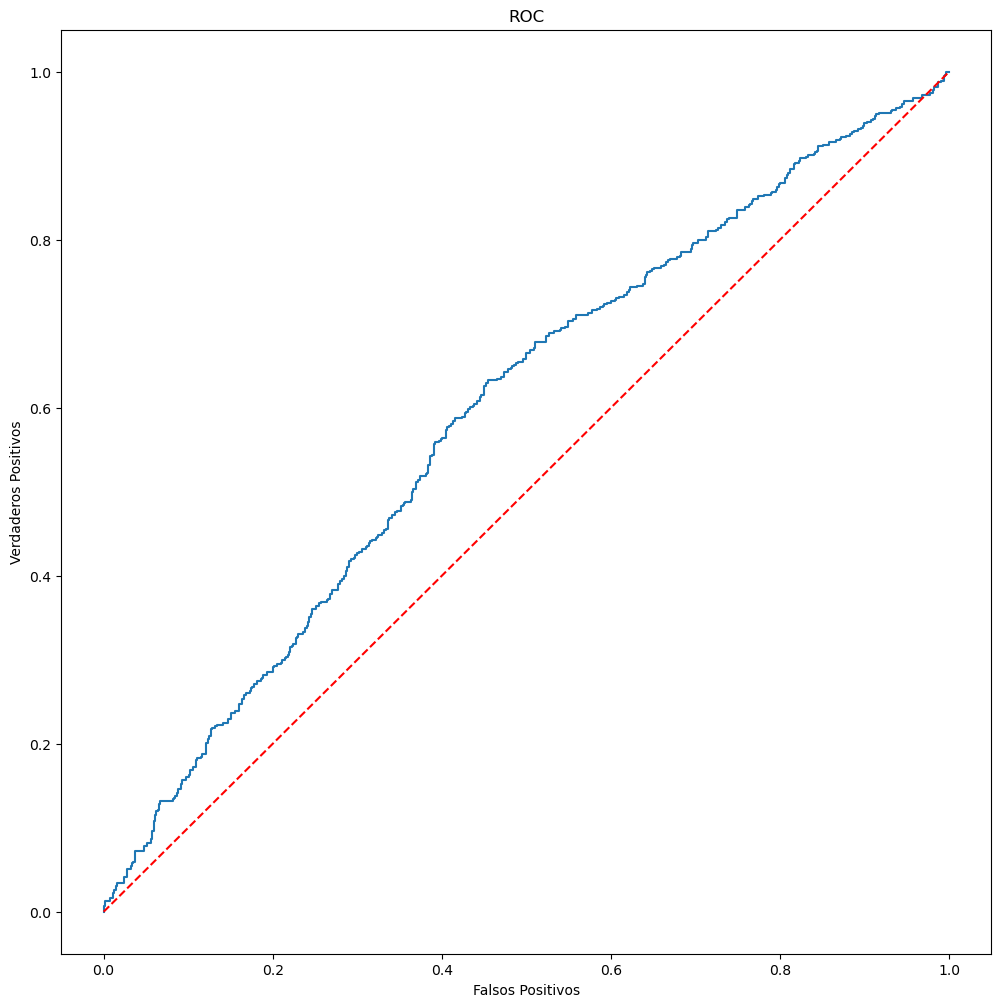

In [52]:
evaluate_model(y_test=y1_test, y_test_prob=y1_test_prob_model, y_test_pred=y1_test_pred_model)

### 4.5 Dividion del dataset (Cluster 2)

In [53]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, Y2, test_size=0.2, random_state=0)

print(u'Dimensiones en train \n-x:{}\n-y:{}'.format(X2_train.shape, y2_train.shape))
print(u'Dimensiones en test \n-x:{}\n-y:{}'.format(X2_test.shape, y2_test.shape))

Dimensiones en train 
-x:(11288, 32)
-y:(11288,)
Dimensiones en test 
-x:(2822, 32)
-y:(2822,)


### 4.6. Regresión Logística (Cluster 2)

In [54]:
logistic_regression = LogisticRegression()

In [55]:
y2_test_pred_model, y2_test_prob_model = model_fit(model=logistic_regression, X_train=X2_train, y_train=y2_train, X_test=X2_test)

Ejemplo de predicción: [[0.74693812 0.25306188]]


- Precision: 0.44
- Recall: 0.0380952380952381
- Fscore: 0.07
- AUC: 0.67


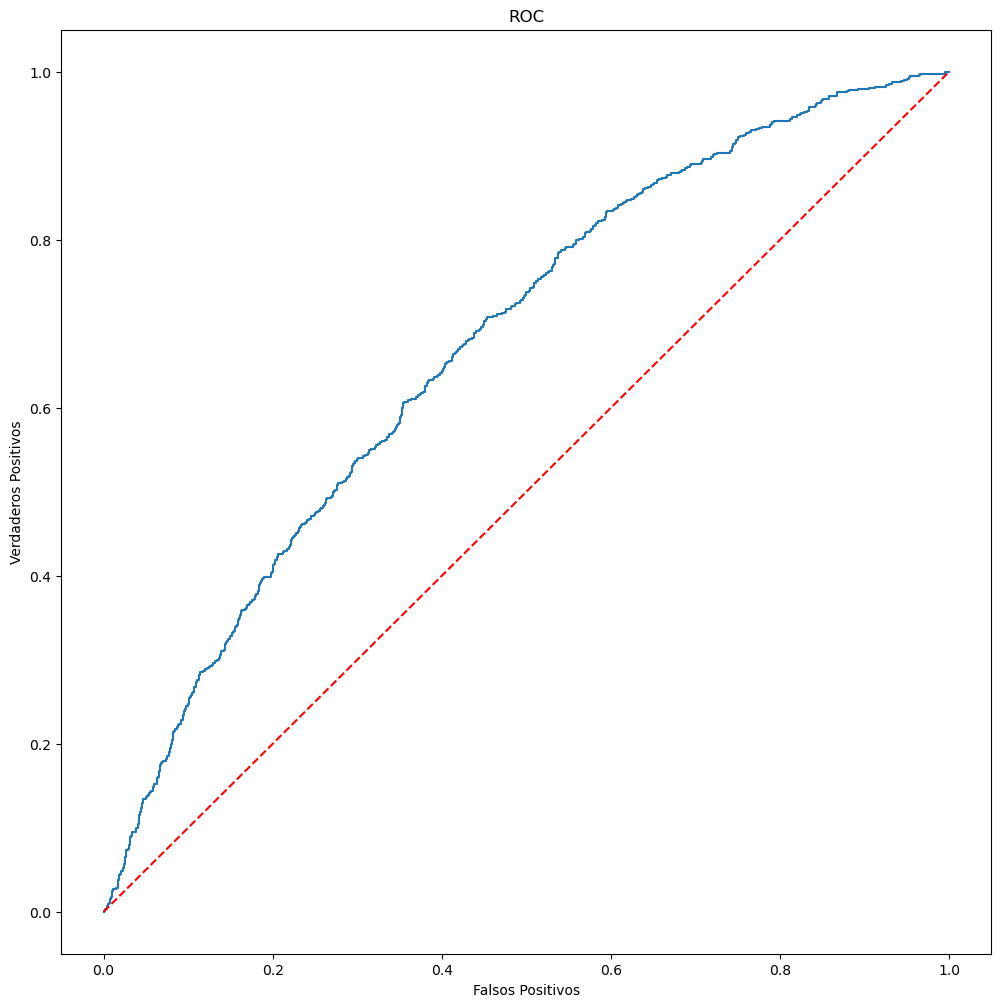

In [56]:
evaluate_model(y_test=y2_test, y_test_prob=y2_test_prob_model, y_test_pred=y2_test_pred_model)

### 4.7. Modelo ensamblado (Cluster 2)

In [57]:
random_forest_classifier = RandomForestClassifier()

In [58]:
y2_test_pred_model, y2_test_prob_model = model_fit(model=random_forest_classifier, X_train=X2_train, y_train=y2_train, X_test=X2_test)

Ejemplo de predicción: [[0.83 0.17]]


- Precision: 0.45
- Recall: 0.08027210884353742
- Fscore: 0.14
- AUC: 0.66


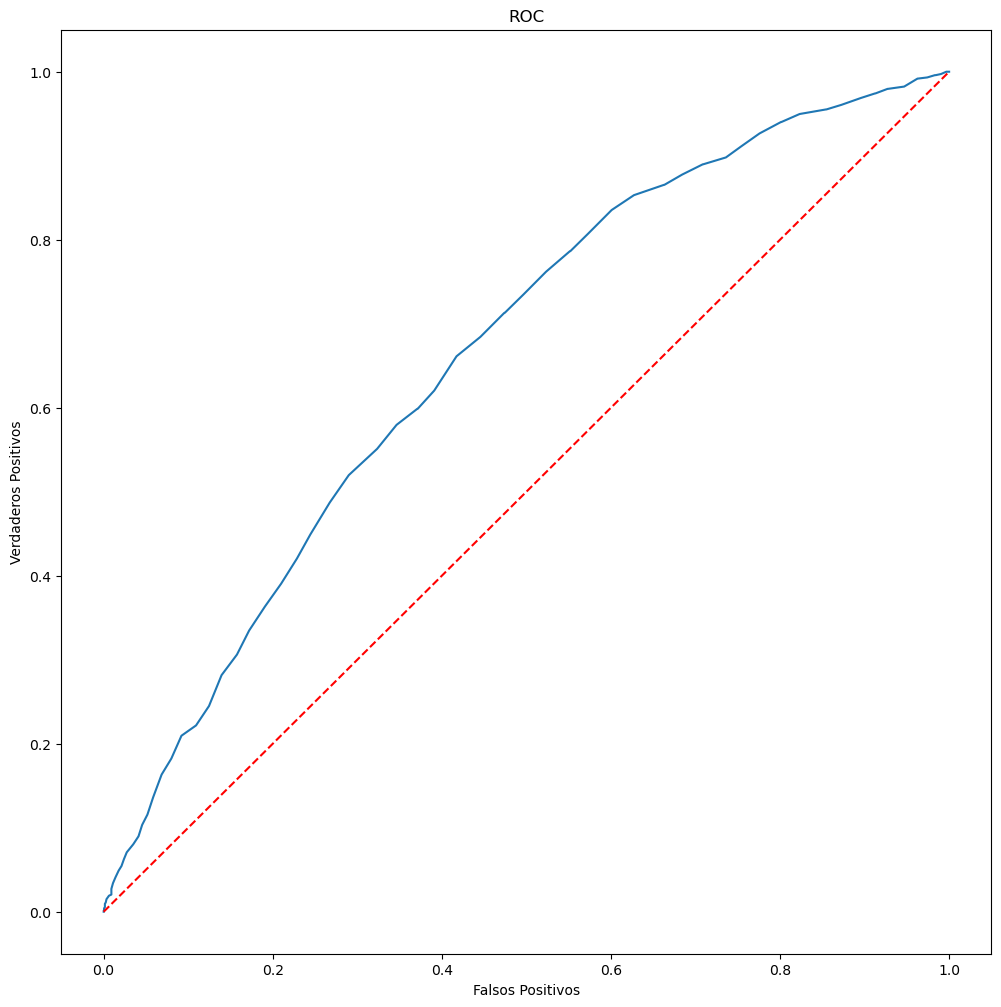

In [59]:
evaluate_model(y_test=y2_test, y_test_prob=y2_test_prob_model, y_test_pred=y2_test_pred_model)

### 4.8. Red neuronal (MLP) (Cluster 2)

In [60]:
mlp = MLPClassifier()

In [61]:
y2_test_pred_model, y2_test_prob_model = model_fit(model=mlp, X_train=X2_train, y_train=y2_train, X_test=X2_test)

Ejemplo de predicción: [[0.8816784 0.1183216]]


- Precision: 0.4
- Recall: 0.1401360544217687
- Fscore: 0.21
- AUC: 0.65


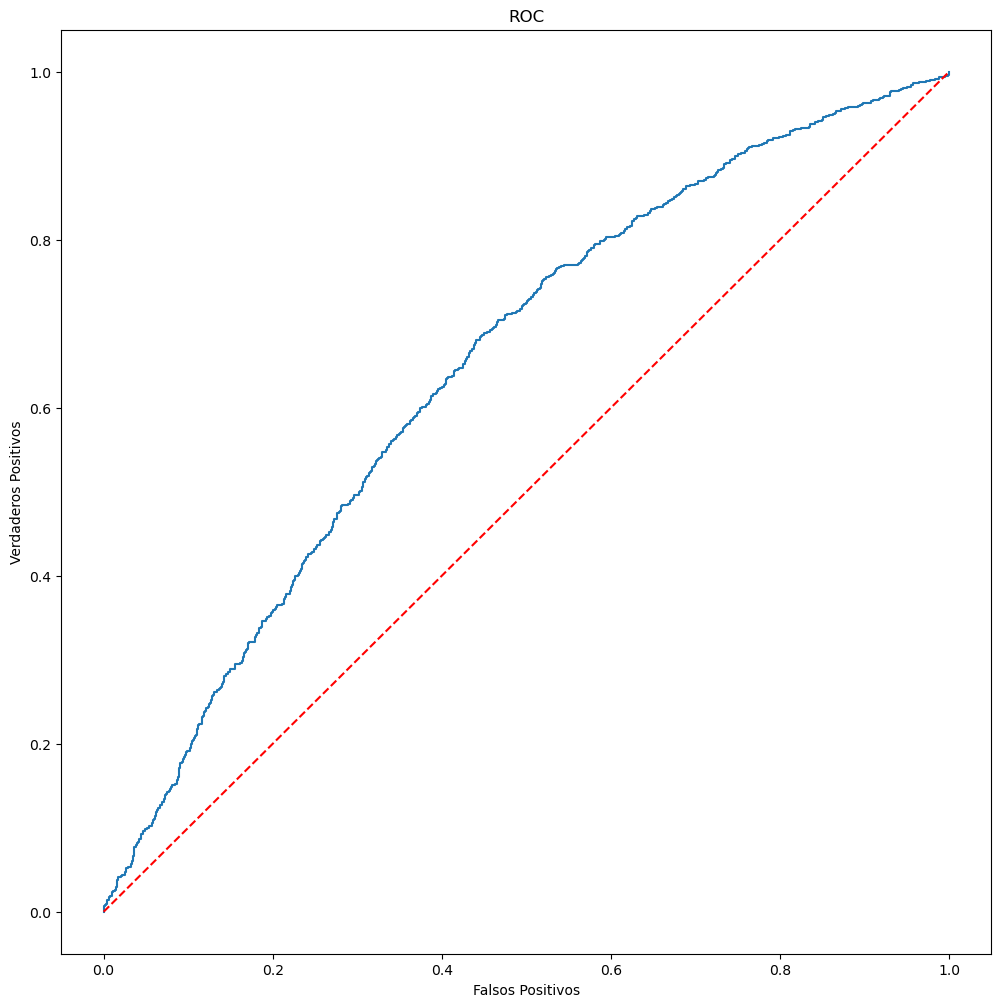

In [62]:
evaluate_model(y_test=y2_test, y_test_prob=y2_test_prob_model, y_test_pred=y2_test_pred_model)

## 5. Tratamiento y análisis de la columna Mes.

Número de outliers por encima: 0
Número de outliers por debajo: 0


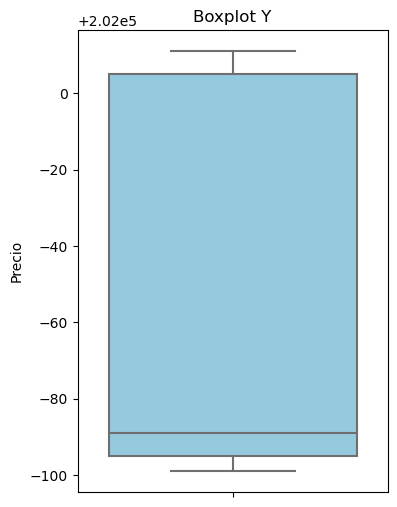

<class 'pandas.core.series.Series'>
RangeIndex: 20000 entries, 0 to 19999
Series name: MES
Non-Null Count  Dtype         
--------------  -----         
20000 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 156.4 KB


count                         20000
mean     2019-11-05 06:08:21.120000
min             2019-01-01 00:00:00
25%             2019-05-01 00:00:00
50%             2019-11-01 00:00:00
75%             2020-05-01 00:00:00
max             2020-11-01 00:00:00
Name: MES, dtype: object

In [63]:
Q1 = df['MES'].quantile(0.25)
Q3 = df['MES'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_above = df['MES'][df['MES'] > upper_bound]
outliers_below = df['MES'][df['MES'] < lower_bound]

print("Número de outliers por encima:", outliers_above.shape[0])
print("Número de outliers por debajo:", outliers_below.shape[0])

plt.figure(figsize=(4, 6))
sns.boxplot(y=df['MES'], color='skyblue', orient='v')
plt.ylabel('Precio')
plt.title('Boxplot Y')
plt.show()

df['MES'] = pd.to_datetime(df['MES'], format='%Y%m')
df['MES'].info()
df['MES'].describe()